In [1]:
import os
import sys
sys.path.append('..') 
import yaml
import pandas as pd
import numpy as np
import pickle
from src.utils.utils_p import YamlParser,Upload_Download_Pickle,Config_Paths,Feature_Selection_Configs,Model_Configs,Create_Labels_Configs
from src.data.CollectData.CollectDataFromCSV import *
from src.preprocessing.Data_Preprocessing import *
from src.combineDatasets.Combine_Datasets import *
from src.featureProcessing.SplitDataset.Split_Train_Test import *
from src.featureProcessing.Feature_Selection.Wrapper import *
from src.featureProcessing.Feature_Selection.Hybrid import *
#from src.processing.Model import *
from src.model.Classification.Random_Forest_Tuning import *
from src.model.Classification.XGBoost_Tuning import *
from src.model.Classification.LightGBM_Tuning import *
from src.model.Classification.CatBoost_Tuning import *
from src.model.Classification.SVC_Tuning import *
from src.model.Classification.Voting import *

In [2]:
path=Config_Paths().get_processed_path()
cpath=Config_Paths().get_combineddatasets_path()

In [3]:
rpath=Config_Paths().get_raw_path()
prepath=Config_Paths().get_intermediate_path()


In [4]:
#PERIOD yerine YEAR_MONTH_DAY geldi.
LogsT02=Upload_Download_Pickle().download_pickle(prepath, 'Features_not_normalT02')
LabelsT02=Upload_Download_Pickle().download_pickle(prepath, 'Labels_not_normalT02')
LogsT03=Upload_Download_Pickle().download_pickle(prepath, 'Features_not_normalT03')
LogsT52=Upload_Download_Pickle().download_pickle(prepath, 'Features_not_normalT52')


In [76]:
LogsT02=pd.merge(LogsT02,LabelsT02[['Pitch systemEv_multiclass','Pitch systemEv','Period']])

In [77]:
from datetime import datetime, timedelta
LogsT02['onedayPeriod']=LogsT02['Period'].astype('datetime64[ns]')- timedelta(days=1)
LogsT02['fivedaysPeriod']=LogsT02['Period'].astype('datetime64[ns]')- timedelta(days=5)
LogsT02['fiftheendaysPeriod']=LogsT02['Period'].astype('datetime64[ns]')- timedelta(days=15)


In [78]:
LogsT02=LogsT02.set_index('Period')
tag=LogsT02[LogsT02['Pitch systemEv']=='EVENT_134']


In [79]:
for i in tag.index:
    print(i)
    print(tag.loc[i,'onedayPeriod'])
    LogsT02['New_Pitch_systemEv']=np.where((LogsT02.index<=i)&(LogsT02.index>tag.loc[i,'fiftheendaysPeriod']),'EVENT_134_fifthteen',0)    
    LogsT02['New_Pitch_systemEv']=np.where((LogsT02.index<=i)&(LogsT02.index>tag.loc[i,'fivedaysPeriod']),'EVENT_134_five',LogsT02['New_Pitch_systemEv'])  
    LogsT02['New_Pitch_systemEv']=np.where((LogsT02.index<=i)&(LogsT02.index>tag.loc[i,'onedayPeriod']),'EVENT_134_one',LogsT02['New_Pitch_systemEv'])
  
    

2020-02-08 13:30:00
2020-02-07 13:30:00
2020-02-08 13:40:00
2020-02-07 13:40:00
2020-02-08 13:50:00
2020-02-07 13:50:00
2020-02-08 14:00:00
2020-02-07 14:00:00


In [122]:
LogsT02 ['New_Pitch_systemEv'].unique()

array(['0', 'EVENT_134_fifthteen', 'EVENT_134_five', 'EVENT_134_one'],
      dtype=object)

In [132]:
tag_plot=LogsT02[LogsT02['New_Pitch_systemEv']!=0]

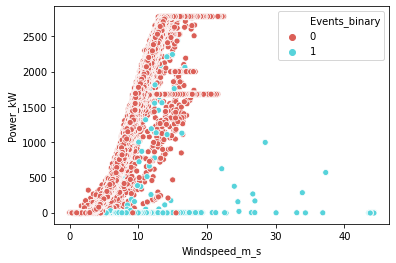

In [133]:
import seaborn as sns
sns.scatterplot(
       x="Windspeed_m_s", y="Power_kW",
       hue="Events_binary",
       palette=sns.color_palette("hls", LogsT02[['Power_kW','Windspeed_m_s','Events_binary']].Events_binary.unique().shape[0]),
       data=tag_plot[['Power_kW','Windspeed_m_s','Events_binary']]
    )

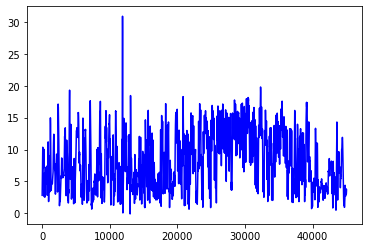

In [147]:
from scipy.signal import lfilter, savgol_filter
w = savgol_filter(tag_plot["Windspeed_m_s"], 101, 2)
plt.plot( w, 'b')  # high frequency noise removed

In [152]:
pip install pykalman

  Created wheel for pykalman: filename=pykalman-0.9.5-cp37-none-any.whl size=48467 sha256=b8599217c1cdc730dc2ea4f8b87b7ca276c4466452b505e0eead6502a09d047d
  Stored in directory: D:\Users\sezgis\AppData\Local\pip\Cache\wheels\d9\e8\6a\553d9832679cb74a8434fa597c3abdb07313e40054a0adf9ac
Successfully built pykalman
Note: you may need to restart the kernel to use updated packages.


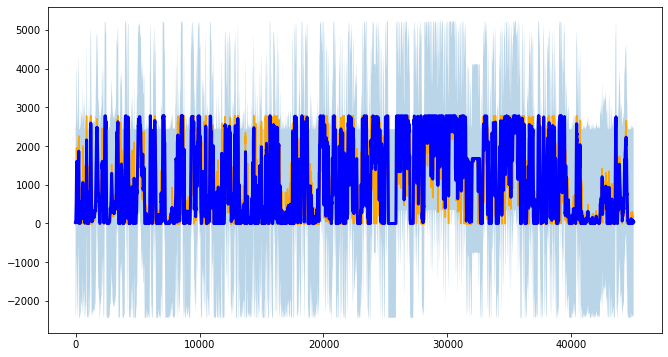

In [158]:
from tsmoothie.smoother import *

smoother = ConvolutionSmoother(window_len=30, window_type='ones')
smoother.smooth(tag_plot["Power_kW"])
# generate intervals
low, up = smoother.get_intervals('sigma_interval', n_sigma=10)

# plot the smoothed timeseries with intervals
plt.figure(figsize=(11,6))
plt.plot(smoother.data[0], color='orange')
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)

In [153]:
from pykalman import KalmanFilter

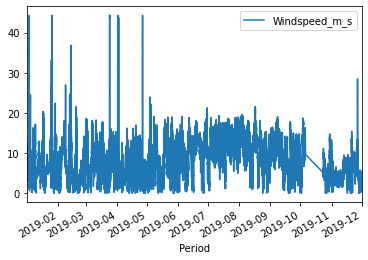

In [144]:
tag_plot[["Windspeed_m_s"]].plot()

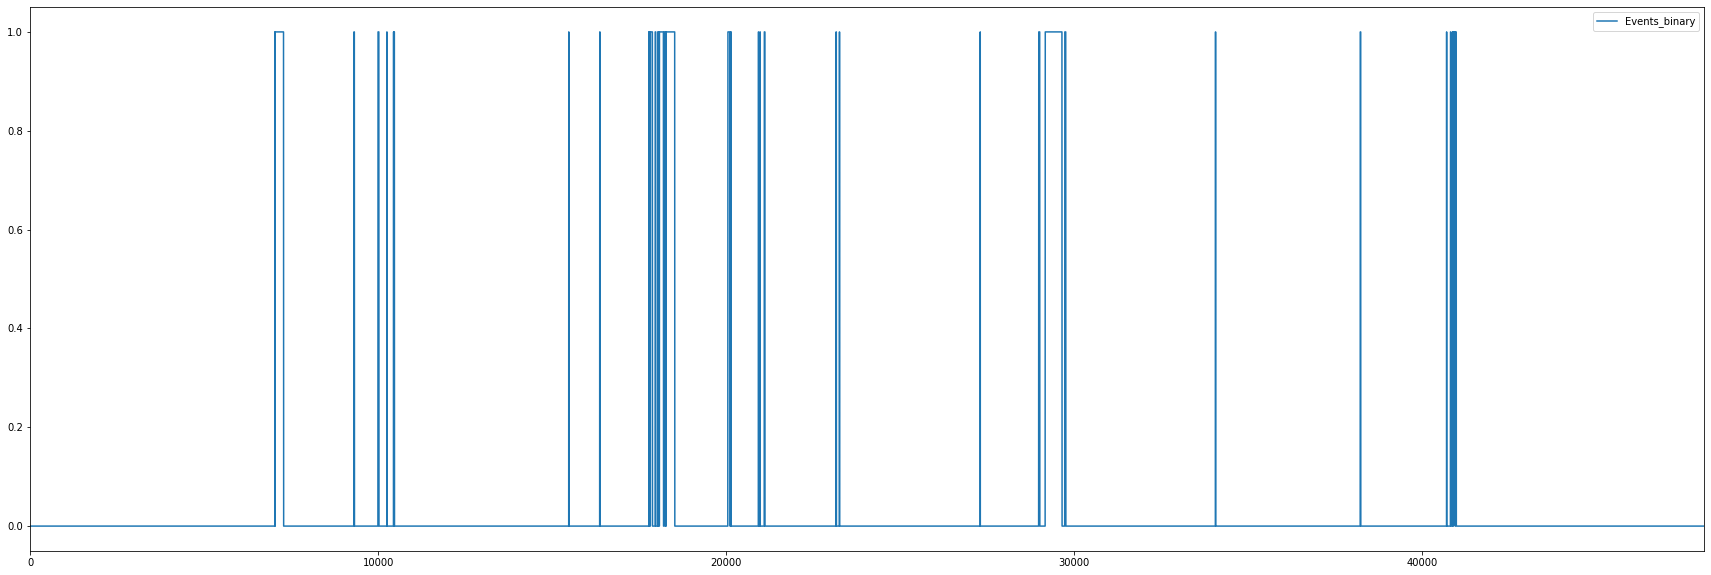

In [136]:
LogsT03 [['Events_binary']].plot(figsize=[30,10])

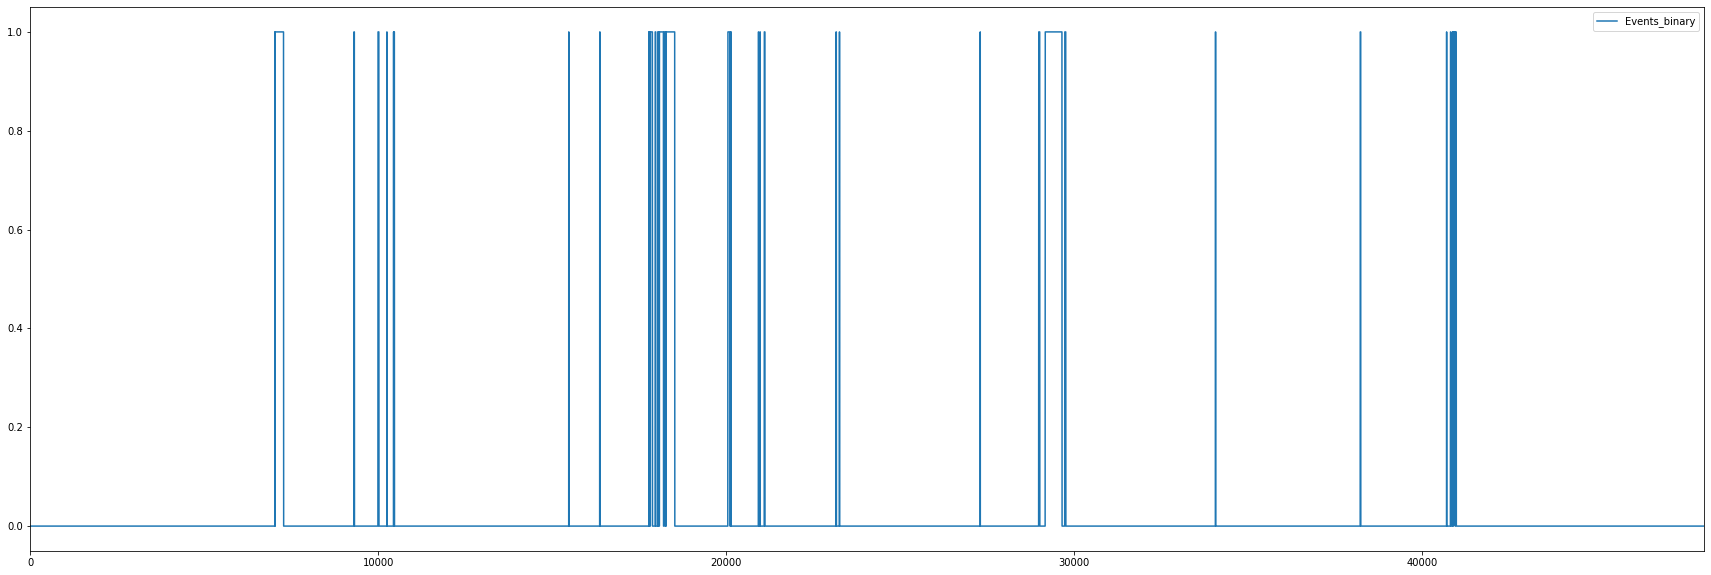

In [123]:
LogsT03 [['Events_binary']].plot(figsize=[30,10])

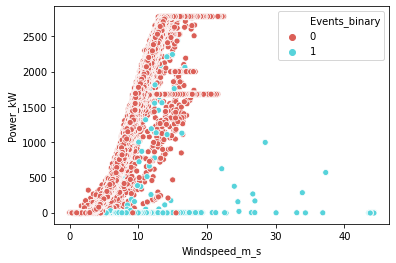

In [14]:
import seaborn as sns
sns.scatterplot(
       x="Windspeed_m_s", y="Power_kW",
       hue="Events_binary",
       palette=sns.color_palette("hls", LogsT02[['Power_kW','Windspeed_m_s','Events_binary']].Events_binary.unique().shape[0]),
       data=LogsT02[['Power_kW','Windspeed_m_s','Events_binary']]
    )

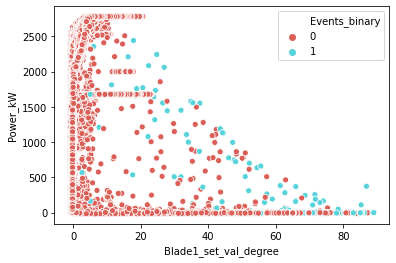

In [15]:
import seaborn as sns
sns.scatterplot(
       x='Blade1_set_val_degree', y="Power_kW",
       hue="Events_binary",
       palette=sns.color_palette("hls", LogsT02[['Power_kW','Blade1_set_val_degree','Events_binary']].Events_binary.unique().shape[0]),
       data=LogsT02[['Power_kW','Blade1_set_val_degree','Events_binary']]
    )

In [16]:
import seaborn as sns
upload_list=[LogsT02,LogsT03]
for data in upload_list:
    #data['Blade1_set_diff_act']= abs(data['Blade1_act_val_degree']-data['Blade1_set_val_degree'])
    for i in data['Pitch systemEv'].unique():
        subset=data[data['Pitch systemEv']==i].copy()
        if i!='0':
            sns.scatterplot(
                   x='Blade1_act_val_degree', y="Power_kW",
                   hue="Pitch systemEv",
                   data=subset[['Power_kW','Blade1_act_val_degree','Pitch systemEv']]
                )

KeyError: 'Pitch systemEv'

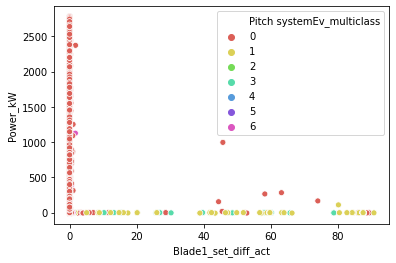

In [17]:
import seaborn as sns
LogsT02['Blade1_set_diff_act']= abs(LogsT02['Blade1_act_val_degree']-LogsT02['Blade1_set_val_degree'])
sns.scatterplot(
       x='Blade1_set_diff_act', y="Power_kW",
       hue="Pitch systemEv_multiclass",
       palette=sns.color_palette("hls", LogsT02[['Power_kW','Blade1_set_diff_act','Pitch systemEv_multiclass']]['Pitch systemEv_multiclass'].unique().shape[0]),
       data=LogsT02[['Power_kW','Blade1_set_diff_act','Pitch systemEv_multiclass']]
    )

In [18]:
LogsT02['Blade1_set_diff_act']= abs(LogsT02['Blade1_act_val_degree']-LogsT02['Blade1_set_val_degree'])
LogsT02[['Power_kW','Blade1_set_diff_act','Pitch systemEv_multiclass']]['Pitch systemEv_multiclass'].unique().shape[0]

7

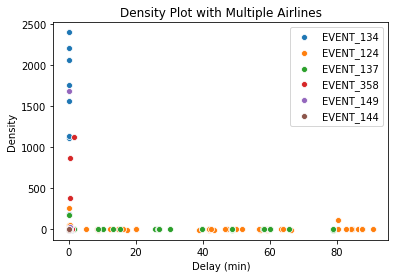

In [19]:
import matplotlib.pyplot as plt
LogsT02=Upload_Download_Pickle().download_pickle(prepath, 'Features_not_normalT02')
LogsT03=Upload_Download_Pickle().download_pickle(prepath, 'Features_not_normalT03')
LogsT52=Upload_Download_Pickle().download_pickle(prepath, 'Features_not_normalT52')
LabelsT02=Upload_Download_Pickle().download_pickle(prepath, 'Labels_not_normalT02')
LabelsT03=Upload_Download_Pickle().download_pickle(prepath, 'Labels_not_normalT03')
LabelsT52=Upload_Download_Pickle().download_pickle(prepath, 'Labels_not_normalT52')
LogsT02=pd.merge(LogsT02,LabelsT02[['Pitch systemEv_multiclass','Pitch systemEv','Pitch system','Events_multiclass','Components','Period']])
LogsT03=pd.merge(LogsT02,LabelsT03[['Pitch systemEv_multiclass','Pitch systemEv','Pitch system','Events_multiclass','Components','Period']])
LogsT52=pd.merge(LogsT02,LabelsT52[['Pitch systemEv_multiclass','Pitch systemEv','Pitch system','Events_multiclass','Components','Period']])
    
upload_list=[LogsT02,LogsT03,LogsT52]
for data in upload_list:
    data['Blade1_set_diff_act']= abs(data['Blade1_act_val_degree']-data['Blade1_set_val_degree'])
    for i in data['Pitch systemEv'].unique():
        subset=data[data['Pitch systemEv']==i].copy()
        if i!='0':
            sns.scatterplot(
                   x='Blade1_set_diff_act', y="Power_kW",
                   palette=sns.color_palette("hls"),
                   label=i+str(),
                   data=subset[['Power_kW','Blade1_set_diff_act','Pitch systemEv']]
                )
    plt.title('Density Plot with Multiple Airlines')
    plt.xlabel('Delay (min)')
    plt.ylabel('Density')

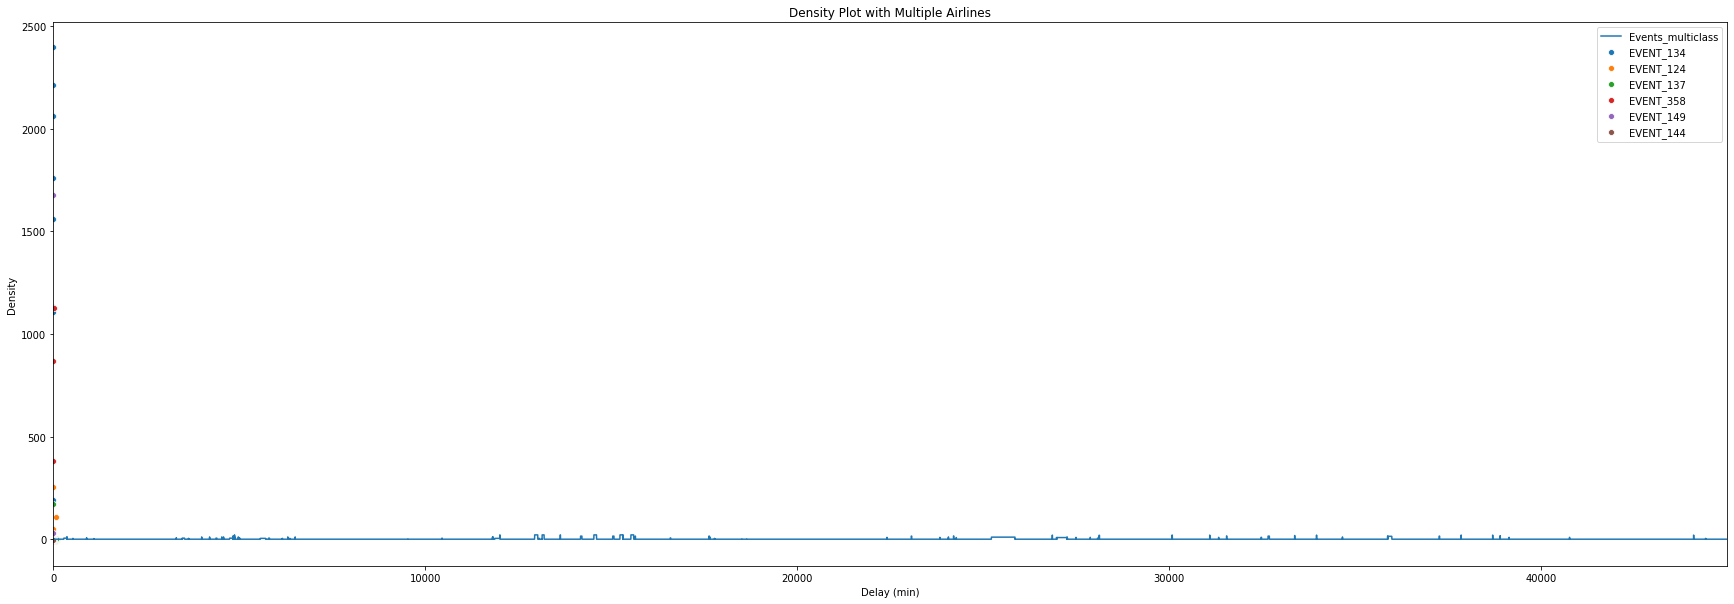

In [20]:
LogsT02 [['Events_multiclass']].plot(figsize=[30,10])
upload_list=[LogsT02,LogsT03,LogsT52]
for data in upload_list:
    data['Blade1_set_diff_act']= abs(data['Blade1_act_val_degree']-data['Blade1_set_val_degree'])
    for i in data['Pitch systemEv'].unique():
        subset=data[data['Pitch systemEv']==i].copy()
        if i!='0':
            sns.scatterplot(
                   x='Blade1_set_diff_act', y="Power_kW",
                   palette=sns.color_palette("hls"),
                   label=i+str(),
                   data=subset[['Power_kW','Blade1_set_diff_act','Pitch systemEv']]
                )
    plt.title('Density Plot with Multiple Airlines')
    plt.xlabel('Delay (min)')
    plt.ylabel('Density')

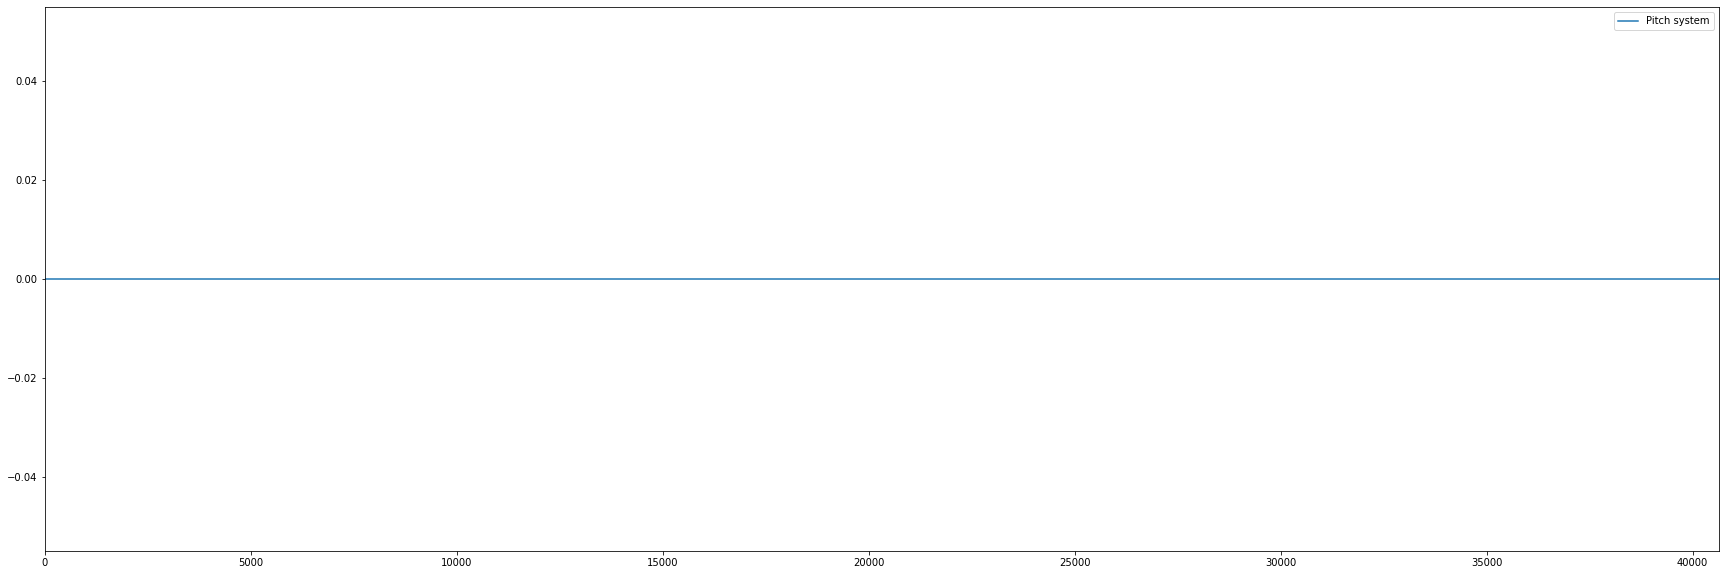

In [21]:
LogsT52 [['Pitch system']].plot(figsize=[30,10])

# Power & Wind Speed

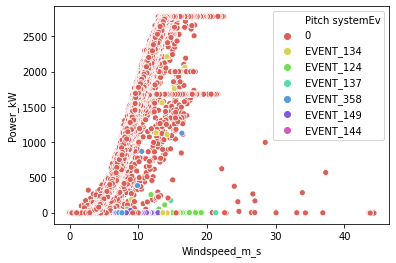

In [22]:
import seaborn as sns
sns.scatterplot(
       x="Windspeed_m_s", y="Power_kW",
       hue='Pitch systemEv',
       palette=sns.color_palette("hls", LogsT02[['Power_kW','Windspeed_m_s','Pitch systemEv']]['Pitch systemEv'].unique().shape[0]),
       data=LogsT02[['Power_kW','Windspeed_m_s','Pitch systemEv']]
    )

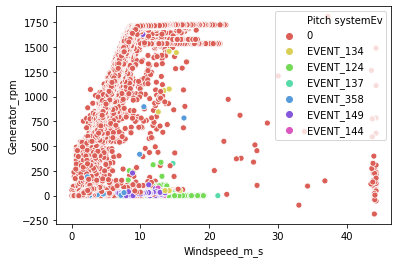

In [28]:
import seaborn as sns
sns.scatterplot(
       x="Windspeed_m_s", y="Generator_rpm",
       hue='Pitch systemEv',
       palette=sns.color_palette("hls", LogsT02[['Generator_rpm','Windspeed_m_s','Pitch systemEv']]['Pitch systemEv'].unique().shape[0]),
       data=LogsT02[['Generator_rpm','Windspeed_m_s','Pitch systemEv']]
    )

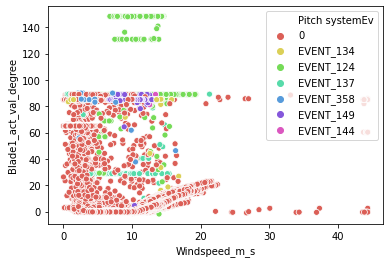

In [32]:
import seaborn as sns
sns.scatterplot(
       x="Windspeed_m_s", y="Blade1_act_val_degree",
       hue='Pitch systemEv',
       palette=sns.color_palette("hls", LogsT02[['Blade1_act_val_degree','Windspeed_m_s','Pitch systemEv']]['Pitch systemEv'].unique().shape[0]),
       data=LogsT02[['Blade1_act_val_degree','Windspeed_m_s','Pitch systemEv']]
    )

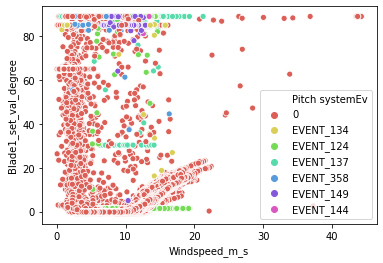

In [33]:
import seaborn as sns
sns.scatterplot(
       x="Windspeed_m_s", y="Blade1_set_val_degree",
       hue='Pitch systemEv',
       palette=sns.color_palette("hls", LogsT02[['Blade1_set_val_degree','Windspeed_m_s','Pitch systemEv']]['Pitch systemEv'].unique().shape[0]),
       data=LogsT02[['Blade1_set_val_degree','Windspeed_m_s','Pitch systemEv']]
    )

# Generator &

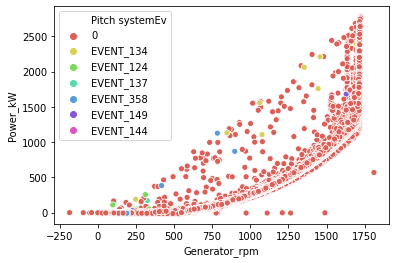

In [27]:
import seaborn as sns
sns.scatterplot(
       x="Generator_rpm", y="Power_kW",
       hue='Pitch systemEv',
       palette=sns.color_palette("hls", LogsT02[['Power_kW','Generator_rpm','Pitch systemEv']]['Pitch systemEv'].unique().shape[0]),
       data=LogsT02[['Power_kW','Generator_rpm','Pitch systemEv']]
    )

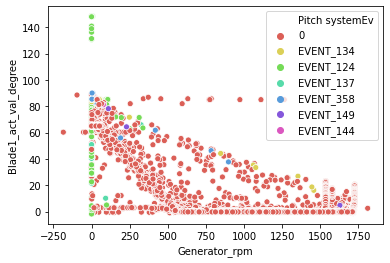

In [29]:
import seaborn as sns
sns.scatterplot(
       x="Generator_rpm", y="Blade1_act_val_degree",
       hue='Pitch systemEv',
       palette=sns.color_palette("hls", LogsT02[['Blade1_act_val_degree','Generator_rpm','Pitch systemEv']]['Pitch systemEv'].unique().shape[0]),
       data=LogsT02[['Blade1_act_val_degree','Generator_rpm','Pitch systemEv']]
    )

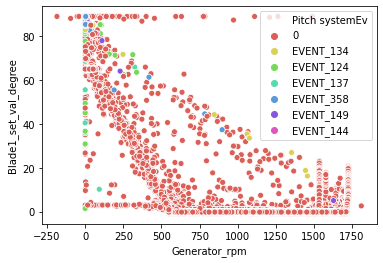

In [30]:
import seaborn as sns
sns.scatterplot(
       x="Generator_rpm", y="Blade1_set_val_degree",
       hue='Pitch systemEv',
       palette=sns.color_palette("hls", LogsT02[['Blade1_set_val_degree','Generator_rpm','Pitch systemEv']]['Pitch systemEv'].unique().shape[0]),
       data=LogsT02[['Blade1_set_val_degree','Generator_rpm','Pitch systemEv']]
    )

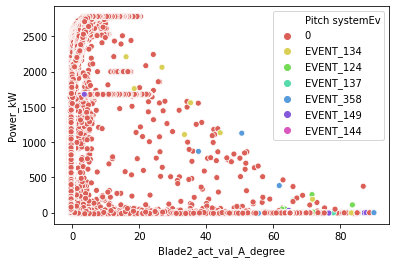

In [31]:
import seaborn as sns
sns.scatterplot(
       x='Blade2_act_val_A_degree', y="Power_kW",
       hue='Pitch systemEv',
       palette=sns.color_palette("hls", LogsT02[['Power_kW','Blade2_act_val_A_degree','Pitch systemEv']]['Pitch systemEv'].unique().shape[0]),
       data=LogsT02[['Power_kW','Blade2_act_val_A_degree','Pitch systemEv']]
    )

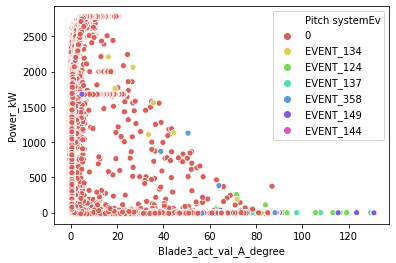

In [24]:
import seaborn as sns
sns.scatterplot(
       x='Blade3_act_val_A_degree', y="Power_kW",
       hue='Pitch systemEv',
       palette=sns.color_palette("hls", LogsT02[['Power_kW','Blade3_act_val_A_degree','Pitch systemEv']]['Pitch systemEv'].unique().shape[0]),
       data=LogsT02[['Power_kW','Blade3_act_val_A_degree','Pitch systemEv']]
    )

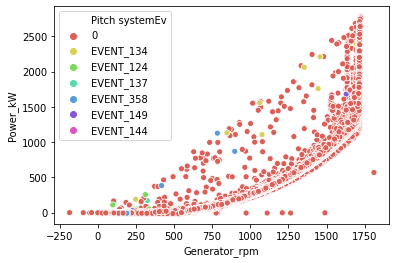

In [25]:
import seaborn as sns
sns.scatterplot(
       x='Generator_rpm', y="Power_kW",
       hue='Pitch systemEv',
       palette=sns.color_palette("hls", LogsT02[['Power_kW','Generator_rpm','Pitch systemEv']]['Pitch systemEv'].unique().shape[0]),
       data=LogsT02[['Power_kW','Generator_rpm','Pitch systemEv']]
    )

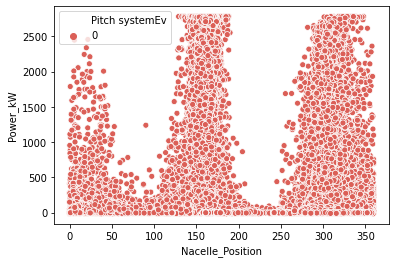

In [157]:
import seaborn as sns
sns.scatterplot(
       x='Nacelle_Position', y="Power_kW",
       hue='Pitch systemEv',
       palette=sns.color_palette("hls", LogsT03[['Power_kW','Nacelle_Position','Pitch systemEv']]['Pitch systemEv'].unique().shape[0]),
       data=LogsT03[['Power_kW','Nacelle_Position','Pitch systemEv']]
    )

In [1]:
import seaborn as sns
LogsT02['Torque_set_diff_act']= abs(LogsT02['Torque_act_Percent']-LogsT02['Torque_set_Percent'])
subset=LogsT02[LogsT02['Components']][['Power_kW','Torque_set_diff_act','Components']]
sns.scatterplot(
       x='Torque_set_diff_act', y="Power_kW",
       hue='Components',
       palette=sns.color_palette("hls", subset['Components'].unique().shape[0]),
       data=subset
    )

NameError: name 'LogsT02' is not defined

(0.0, 1.0)

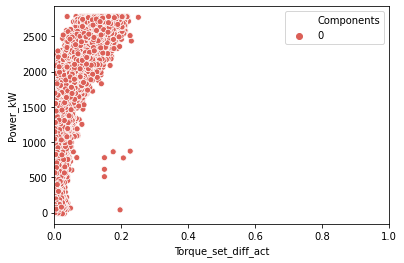

In [165]:
import seaborn as sns
LogsT02['Torque_set_diff_act']= abs(LogsT02['Torque_act_Percent']-LogsT02['Torque_set_Percent'])
subset=LogsT02[LogsT02['Components']=='0'][['Power_kW','Torque_set_diff_act','Components']]
sns.scatterplot(
       x='Torque_set_diff_act', y="Power_kW",
       hue='Components',
       palette=sns.color_palette("hls", subset['Components'].unique().shape[0]),
       data=subset
    )
import matplotlib.pyplot as plt
plt.xlim(0, 1)

In [155]:
LogsT02.columns

Index(['Period', 'Power_kW', 'Rotor_rpm', 'Nacelle_Position', 'Generator_rpm',
       'Torque_act_Percent', 'Torque_set_Percent', 'Tower_acc_normal',
       'Tower_acc_lateral', 'Tower_base_temp_C', 'Ambient_temp_C',
       'Windspeed_m_s', 'gearboxbearing_temp_C',
       'GBX_bearing_hollow_shaft_temp_C', 'GBX_OIL1_temp_C', 'GBX_OIL2_temp_C',
       'GBX_T1_HSS_temp_C', 'GBX_T3_HSS_temp_C', 'GBX_T1_IMS_temp_C',
       'GBX_T3_IMS_temp_C', 'GBX_Distr_temp_C', 'GBX_OIL_temp_C',
       'Shaft_bearing1_temp_C', 'Shaft_bearing2_temp_C', 'Prox_sensor45_mm',
       'Prox_sensor135_mm', 'Prox_sensor225_mm', 'Prox_sensor315_mm',
       'Blade2_act_val_A_degree', 'Blade3_act_val_A_degree',
       'Blade1_set_val_degree', 'Blade1_act_val_degree', 'Events_binary',
       'Pitch systemEv_multiclass', 'Pitch systemEv', 'Blade1_set_diff_act',
       'Torque_set_diff_act'],
      dtype='object')

Text(0, 0.5, 'Density')

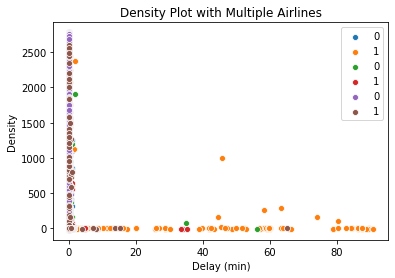

In [118]:
import matplotlib.pyplot as plt
LogsT02=Upload_Download_Pickle().download_pickle(prepath, 'Features_not_normalT02')
LogsT03=Upload_Download_Pickle().download_pickle(prepath, 'Features_not_normalT03')
LogsT52=Upload_Download_Pickle().download_pickle(prepath, 'Features_not_normalT52')
upload_list=[LogsT02,LogsT03,LogsT52]
for data in upload_list:
    data['Blade1_set_diff_act']= abs(data['Blade1_act_val_degree']-data['Blade1_set_val_degree'])
    for i in data.Events_binary.unique():
        subset=data[data.Events_binary==i].copy()
        sns.scatterplot(
               x='Blade1_set_diff_act', y="Power_kW",
               palette=sns.color_palette("hls"),
               label=i,
               data=subset[['Power_kW','Blade1_set_diff_act','Events_binary']]
            )
    plt.title('Density Plot with Multiple Airlines')
    plt.xlabel('Delay (min)')
    plt.ylabel('Density')

In [ ]:
## LogsT03[LogsT03.Events_binary==1]['Blade1_set_diff_act']

In [4]:
#CollectData from given dataset
CollectDataFromCSV().upload_all_datasets() 

file_list :  T02.xls  sheet_name :  FEBRUARY  shape: (4229, 134)
(4137, 147)
file_list :  T02.xls  sheet_name :  MARCH  shape: (8366, 146)
(3943, 135)


..\src\data\CollectData\CollectDataFromCSV.py:179: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  dataf=pd.concat([dataf,combined_dataf[i].set_index(refcolumn)])


WARNING *** file size (83267) not 512 + multiple of sector size (512)


In [13]:
LogsT02=Upload_Download_Pickle().download_pickle(rpath, 'LogsT02')

In [14]:
FaultsT02=Upload_Download_Pickle().download_pickle(rpath, 'FaultsT02')

In [19]:
FaultsT02.head()

System              Start Time                End Time  \
0  Bahce 02 2020-01-14 11:23:20.730 2020-01-14 11:26:57.850   
1  Bahce 02 2020-01-17 08:47:02.740 2020-01-17 08:59:01.560   
2  Bahce 02 2020-01-17 15:37:45.720 2020-01-17 17:14:15.240   
3  Bahce 02 2020-01-23 06:08:00.560 2020-01-23 06:15:26.270   
4  Bahce 02 2020-01-24 12:14:39.180 2020-01-24 12:22:13.520   

  Duration (hh:mm:ss)   Event ID             Category  \
0            00:03:37  EVENT_358               Unused   
1            00:11:59  EVENT_141  Frequency Converter   
2            01:36:30  EVENT_157                Brake   
3            00:07:26  EVENT_106  Frequency Converter   
4            00:07:34  EVENT_001             No Fault   

                       Description Lost Production (kWh)  
0   Malfunction Triplepitch System                  1,25  
1  Gen. side CCU collective faults                436,01  
2             Brake does not close                943,41  
3      Gen. side CCU fault current                461,82  
4                 Programstart PLC                134,67

In [52]:
sum_list=LogsT02.isna().sum()

In [66]:
LogsT02[['Bahce 02 Operating state','Bahce 02 n-set 1 (rpm).1']]

Bahce 02 Operating state  Bahce 02 n-set 1 (rpm).1
Unnamed: 0                                                             
2020-01-01 00:10:00                 16.000000                       NaN
2020-01-01 00:20:00                 16.000000                       NaN
2020-01-01 00:30:00                 16.000000                       NaN
2020-01-01 00:40:00                 16.000000                       NaN
2020-01-01 00:50:00                 16.000000                       NaN
2020-01-01 01:00:00                 16.000000                       NaN
2020-01-01 01:10:00                 16.000000                       NaN
2020-01-01 01:20:00                 16.000000                       NaN
2020-01-01 01:30:00                 16.000000                       NaN
2020-01-01 01:40:00                 16.000000                       NaN
2020-01-01 01:50:00                 16.000000                       NaN
2020-01-01 02:00:00                 16.000000                       NaN
2020-01-01 02:10:00                 16.000000                       NaN
2020-01-01 02:20:00                 16.000000                       NaN
2020-01-01 02:30:00                 16.000000                       NaN
2020-01-01 02:40:00                 16.000000                       NaN
2020-01-01 02:50:00                 16.000000                       NaN
2020-01-01 03:00:00                 16.000000                       NaN
2020-01-01 03:10:00                 16.000000                       NaN
2020-01-01 03:20:00                 16.000000                       NaN
2020-01-01 03:30:00                 16.000000                       NaN
2020-01-01 03:40:00                 16.000000                       NaN
2020-01-01 03:50:00                 16.000000                       NaN
2020-01-01 04:00:00                 16.000000                       NaN
2020-01-01 04:10:00                 16.000000                       NaN
2020-01-01 04:20:00                 16.000000                       NaN
2020-01-01 04:30:00                 16.000000                       NaN
2020-01-01 04:40:00                 16.000000                       NaN
2020-01-01 04:50:00                 16.000000                       NaN
2020-01-01 05:00:00                 16.000000                       NaN
2020-01-01 05:10:00                 16.000000                       NaN
2020-01-01 05:20:00                 16.000000                       NaN
2020-01-01 05:30:00                 16.000000                       NaN
2020-01-01 05:40:00                 16.000000                       NaN
2020-01-01 05:50:00                 16.000000                       NaN
2020-01-01 06:00:00                 16.000000                       NaN
2020-01-01 06:10:00                 16.000000                       NaN
2020-01-01 06:20:00                 16.000000                       NaN
2020-01-01 06:30:00                 16.000000                       NaN
2020-01-01 06:40:00                 16.000000                       NaN
2020-01-01 06:50:00                 16.000000                       NaN
2020-01-01 07:00:00                 16.000000                       NaN
2020-01-01 07:10:00                 16.000000                       NaN
2020-01-01 07:20:00                 16.000000                       NaN
2020-01-01 07:30:00                 16.000000                       NaN
2020-01-01 07:40:00                 16.000000                       NaN
2020-01-01 07:50:00                 16.000000                       NaN
2020-01-01 08:00:00                 16.000000                       NaN
2020-01-01 08:10:00                 16.000000                       NaN
2020-01-01 08:20:00                 16.000000                       NaN
2020-01-01 08:30:00                 16.000000                       NaN
2020-01-01 08:40:00                 16.000000                       NaN
2020-01-01 08:50:00                 16.000000                       NaN
2020-01-01 09:00:00                 16.000000                

In [25]:
LogsT02.index.name

'Unnamed: 0'

In [ ]:
#CollectData from given dataset
CollectDataFromCSV().upload_all_datasets() 

#Clearn-Normalize-Combine dataset
Data_Preprocessing().preprocessing()

In [ ]:
Features_not_normalT02=Upload_Download_Pickle().download_pickle(prepath, 'Features_not_normalT02')
Labels_not_normalT02=Upload_Download_Pickle().download_pickle(prepath, 'Labels_not_normalT02')

In [ ]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [ ]:
Labels_not_normalT02['Pitch systemEv'].unique()

In [ ]:
Labels_not_normalT02.columns

In [ ]:
Features_not_normalT02.head()

In [ ]:
#Combine Multiple Identical Datasets
Combine_Datasets().multi_combine_dataset()

In [ ]:
#PERIOD yerine YEAR_MONTH_DAY geldi.
Features_df=Upload_Download_Pickle().download_pickle(cpath, 'Features_df')
AllLabels_df=Upload_Download_Pickle().download_pickle(cpath, 'AllLabels_df')
Labels_df=Upload_Download_Pickle().download_pickle(cpath, 'Labels_df')


In [ ]:
Features_df[Features_df['TURBINE_NUMBER'].isin(['T02'])].head()

In [159]:
#Split Hold-0ut Dataset
Split_Train_Test().split_train_testset()

X_test (3078, 146)
y_test (3078,)
X_list[i] shape: (12309, 146)
y_list[i] shape: (12309, 1)
X_test_list 2462
y_tests_list 2462
X_trains_list 9847
y_trains_list 9847


In [162]:
Features_df['Turbine_State'].unique()

array([0.        , 0.27712858, 0.49499166, 0.5       , 0.12625417,
       0.17111853, 0.07512522, 0.02170283, 0.25041735, 0.04333332,
       0.24457428, 0.05592653, 0.12333333, 0.08764607, 0.08263773,
       0.34974957, 0.4081803 , 0.17278799, 0.31333333, 0.25792986,
       0.00751251, 0.05008346, 0.11789298, 0.22704509, 0.39833331,
       0.20116863, 0.05276382, 0.44073457, 0.34808016, 0.07846412,
       0.03749999, 0.34223706, 0.40567613, 0.05083334, 0.34056759,
       0.49582636, 0.39482468, 0.31969953, 0.09432387, 0.16611019,
       0.75      , 0.62729549, 0.05509183, 0.07499999, 0.12771285,
       0.4691152 , 0.057596  , 0.07011685, 0.13879597, 0.06510851,
       0.05425709, 0.04841402, 0.05000001, 0.06010017, 0.09515861,
       0.00752509, 0.10350585, 0.4382304 , 0.48996657, 0.23372287,
       0.05342236, 0.11185309, 0.44407344, 0.48500001, 0.21166667,
       0.48831385, 0.31051755, 0.2345576 , 0.32583332, 0.05091819,
       0.06856188, 0.11018363, 0.44816053, 0.115192  , 0.23745

In [154]:
#Feature Selection with Hybrid method
Hybrid().featureSelection()

D:\Users\sezgis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\sezgis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\sezgis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\sezgis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in

In [155]:
# Create & Predict 
XGBoost_Tune().Model()
LightGBM_Tune().Model()
CatBoost_Tune().Model()
#Random_Forest_Tune().Model()
#Voting().Model()
#SVC_Tune().Model()

{'max_depth': [5], 'min_child_weight': [0.01]}
{'cv': 5, 'error_score': 'raise-deprecating', 'estimator__base_score': 0.5, 'estimator__booster': 'gbtree', 'estimator__colsample_bylevel': 1, 'estimator__colsample_bynode': 1, 'estimator__colsample_bytree': 1, 'estimator__gamma': 0, 'estimator__learning_rate': 0.1, 'estimator__max_delta_step': 0, 'estimator__max_depth': 3, 'estimator__min_child_weight': 1, 'estimator__missing': None, 'estimator__n_estimators': 100, 'estimator__n_jobs': 10, 'estimator__nthread': None, 'estimator__objective': 'binary:logistic', 'estimator__random_state': 23, 'estimator__reg_alpha': 0, 'estimator__reg_lambda': 1, 'estimator__scale_pos_weight': 1, 'estimator__seed': None, 'estimator__silent': None, 'estimator__subsample': 1, 'estimator__verbosity': 1, 'estimator': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
  

D:\Users\sezgis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Users\sezgis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X_tests_list Index(['Power_kW', 'Rotor_rpm', 'Nacelle_Position', 'Generator_rpm',
       'Torque_act_Percent', 'Torque_set_Percent', 'Tower_acc_normal',
       'Tower_acc_lateral', 'Tower_base_temp_C', 'Ambient_temp_C',
       'Windspeed_m_s', 'gearboxbearing_temp_C',
       'GBX_bearing_hollow_shaft_temp_C', 'GBX_OIL1_temp_C', 'GBX_OIL2_temp_C',
       'GBX_T1_HSS_temp_C', 'GBX_T3_HSS_temp_C', 'GBX_T1_IMS_temp_C',
       'GBX_T3_IMS_temp_C', 'GBX_Distr_temp_C', 'GBX_OIL_temp_C',
       'Shaft_bearing1_temp_C', 'Shaft_bearing2_temp_C', 'Prox_sensor45_mm',
       'Prox_sensor135_mm', 'Prox_sensor225_mm', 'Prox_sensor315_mm',
       'Blade2_act_val_A_degree', 'Blade3_act_val_A_degree',
       'Blade1_set_val_degree', 'Blade1_act_val_degree'],
      dtype='object')
selectedfeatures Index(['Blade2_act_val_A_degree', 'Blade3_act_val_A_degree',
       'Blade1_act_val_degree', 'Generator_rpm', 'gearboxbearing_temp_C',
       'GBX_T3_HSS_temp_C', 'GBX_bearing_hollow_shaft_temp_C',
       'GBX_

parameters {'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'min_child_weight': [0.01, 0.1, 1.0, 10.0, 100.0]}
{'cv': 10, 'error_score': 'raise-deprecating', 'estimator__boosting_type': 'gbdt', 'estimator__class_weight': None, 'estimator__colsample_bytree': 1.0, 'estimator__importance_type': 'split', 'estimator__learning_rate': 0.1, 'estimator__max_depth': -1, 'estimator__min_child_samples': 20, 'estimator__min_child_weight': 0.001, 'estimator__min_split_gain': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': 10, 'estimator__num_leaves': 31, 'estimator__objective': None, 'estimator__random_state': 23, 'estimator__reg_alpha': 0.0, 'estimator__reg_lambda': 0.0, 'estimator__silent': True, 'estimator__subsample': 1.0, 'estimator__subsample_for_bin': 200000, 'estimator__subsample_freq': 0, 'estimator': LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_

D:\Users\sezgis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Users\sezgis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X_tests_list Index(['Power_kW', 'Rotor_rpm', 'Nacelle_Position', 'Generator_rpm',
       'Torque_act_Percent', 'Torque_set_Percent', 'Tower_acc_normal',
       'Tower_acc_lateral', 'Tower_base_temp_C', 'Ambient_temp_C',
       'Windspeed_m_s', 'gearboxbearing_temp_C',
       'GBX_bearing_hollow_shaft_temp_C', 'GBX_OIL1_temp_C', 'GBX_OIL2_temp_C',
       'GBX_T1_HSS_temp_C', 'GBX_T3_HSS_temp_C', 'GBX_T1_IMS_temp_C',
       'GBX_T3_IMS_temp_C', 'GBX_Distr_temp_C', 'GBX_OIL_temp_C',
       'Shaft_bearing1_temp_C', 'Shaft_bearing2_temp_C', 'Prox_sensor45_mm',
       'Prox_sensor135_mm', 'Prox_sensor225_mm', 'Prox_sensor315_mm',
       'Blade2_act_val_A_degree', 'Blade3_act_val_A_degree',
       'Blade1_set_val_degree', 'Blade1_act_val_degree'],
      dtype='object')
selectedfeatures Index(['Blade2_act_val_A_degree', 'Blade3_act_val_A_degree',
       'Blade1_act_val_degree', 'Generator_rpm', 'gearboxbearing_temp_C',
       'GBX_T3_HSS_temp_C', 'GBX_bearing_hollow_shaft_temp_C',
       'GBX_

parameters {'depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'l2_leaf_reg': [0.01, 0.1, 1.0, 10.0, 100.0]}
{'depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'l2_leaf_reg': [0.01, 0.1, 1.0, 10.0, 100.0]}
{'cv': 10, 'error_score': 'raise-deprecating', 'estimator__learning_rate': 0.1, 'estimator__n_estimators': 100, 'estimator': <catboost.core.CatBoostClassifier object at 0x000002191CFFEBC8>, 'iid': 'warn', 'n_jobs': None, 'param_grid': {'depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'l2_leaf_reg': [0.01, 0.1, 1.0, 10.0, 100.0]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': make_scorer(f1_score), 'verbose': 0}
0:	learn: 0.6012546	total: 98.4ms	remaining: 9.74s
1:	learn: 0.5264868	total: 128ms	remaining: 6.29s
2:	learn: 0.4638006	total: 157ms	remaining: 5.09s
3:	learn: 0.4107097	total: 185ms	remaining: 4.44s
4:	learn: 0.3651784	total: 215ms	remaining: 4.09s
5:	learn: 0.3260768	total: 245ms	remaining: 3.84s
6:	learn: 0.2921527	total: 279ms	remainin

51:	learn: 0.0191993	total: 1.59s	remaining: 1.46s
52:	learn: 0.0188874	total: 1.61s	remaining: 1.43s
53:	learn: 0.0184834	total: 1.65s	remaining: 1.4s
54:	learn: 0.0181738	total: 1.67s	remaining: 1.37s
55:	learn: 0.0178703	total: 1.7s	remaining: 1.34s
56:	learn: 0.0176092	total: 1.73s	remaining: 1.31s
57:	learn: 0.0172998	total: 1.76s	remaining: 1.27s
58:	learn: 0.0170280	total: 1.79s	remaining: 1.25s
59:	learn: 0.0168955	total: 1.82s	remaining: 1.21s
60:	learn: 0.0166676	total: 1.85s	remaining: 1.18s
61:	learn: 0.0164339	total: 1.88s	remaining: 1.15s
62:	learn: 0.0161853	total: 1.91s	remaining: 1.12s
63:	learn: 0.0160718	total: 1.94s	remaining: 1.09s
64:	learn: 0.0159587	total: 1.97s	remaining: 1.06s
65:	learn: 0.0157675	total: 2s	remaining: 1.03s
66:	learn: 0.0156028	total: 2.03s	remaining: 1s
67:	learn: 0.0154705	total: 2.06s	remaining: 970ms
68:	learn: 0.0151128	total: 2.09s	remaining: 941ms
69:	learn: 0.0150143	total: 2.12s	remaining: 910ms
70:	learn: 0.0148829	total: 2.15s	remai

13:	learn: 0.1447351	total: 428ms	remaining: 2.63s
14:	learn: 0.1318745	total: 458ms	remaining: 2.6s
15:	learn: 0.1206556	total: 488ms	remaining: 2.56s
16:	learn: 0.1103199	total: 518ms	remaining: 2.53s
17:	learn: 0.1011776	total: 547ms	remaining: 2.49s
18:	learn: 0.0927851	total: 576ms	remaining: 2.46s
19:	learn: 0.0853216	total: 612ms	remaining: 2.45s
20:	learn: 0.0788406	total: 647ms	remaining: 2.43s
21:	learn: 0.0729778	total: 678ms	remaining: 2.4s
22:	learn: 0.0673366	total: 707ms	remaining: 2.37s
23:	learn: 0.0623959	total: 736ms	remaining: 2.33s
24:	learn: 0.0579953	total: 766ms	remaining: 2.3s
25:	learn: 0.0540937	total: 793ms	remaining: 2.26s
26:	learn: 0.0504921	total: 825ms	remaining: 2.23s
27:	learn: 0.0472482	total: 864ms	remaining: 2.22s
28:	learn: 0.0444402	total: 902ms	remaining: 2.21s
29:	learn: 0.0419742	total: 937ms	remaining: 2.19s
30:	learn: 0.0396480	total: 970ms	remaining: 2.16s
31:	learn: 0.0376233	total: 1s	remaining: 2.13s
32:	learn: 0.0356904	total: 1.04s	rem

76:	learn: 0.0134801	total: 2.6s	remaining: 778ms
77:	learn: 0.0133666	total: 2.63s	remaining: 743ms
78:	learn: 0.0132721	total: 2.67s	remaining: 710ms
79:	learn: 0.0131901	total: 2.7s	remaining: 675ms
80:	learn: 0.0130845	total: 2.73s	remaining: 640ms
81:	learn: 0.0129950	total: 2.76s	remaining: 606ms
82:	learn: 0.0129033	total: 2.79s	remaining: 572ms
83:	learn: 0.0128225	total: 2.82s	remaining: 538ms
84:	learn: 0.0127452	total: 2.85s	remaining: 504ms
85:	learn: 0.0126835	total: 2.88s	remaining: 470ms
86:	learn: 0.0126310	total: 2.92s	remaining: 436ms
87:	learn: 0.0125571	total: 2.94s	remaining: 402ms
88:	learn: 0.0124853	total: 2.97s	remaining: 368ms
89:	learn: 0.0124020	total: 3s	remaining: 334ms
90:	learn: 0.0123317	total: 3.03s	remaining: 300ms
91:	learn: 0.0122788	total: 3.06s	remaining: 267ms
92:	learn: 0.0121115	total: 3.1s	remaining: 233ms
93:	learn: 0.0120417	total: 3.13s	remaining: 200ms
94:	learn: 0.0120111	total: 3.16s	remaining: 166ms
95:	learn: 0.0119663	total: 3.19s	rem

38:	learn: 0.0257243	total: 1.2s	remaining: 1.87s
39:	learn: 0.0247154	total: 1.23s	remaining: 1.84s
40:	learn: 0.0237582	total: 1.26s	remaining: 1.81s
41:	learn: 0.0229511	total: 1.29s	remaining: 1.78s
42:	learn: 0.0221597	total: 1.32s	remaining: 1.75s
43:	learn: 0.0214123	total: 1.35s	remaining: 1.72s
44:	learn: 0.0207561	total: 1.39s	remaining: 1.69s
45:	learn: 0.0201855	total: 1.42s	remaining: 1.66s
46:	learn: 0.0196825	total: 1.45s	remaining: 1.63s
47:	learn: 0.0193554	total: 1.47s	remaining: 1.6s
48:	learn: 0.0189284	total: 1.5s	remaining: 1.57s
49:	learn: 0.0185005	total: 1.53s	remaining: 1.53s
50:	learn: 0.0182103	total: 1.56s	remaining: 1.5s
51:	learn: 0.0178169	total: 1.59s	remaining: 1.47s
52:	learn: 0.0175662	total: 1.62s	remaining: 1.44s
53:	learn: 0.0171643	total: 1.66s	remaining: 1.41s
54:	learn: 0.0168231	total: 1.69s	remaining: 1.38s
55:	learn: 0.0165452	total: 1.72s	remaining: 1.35s
56:	learn: 0.0163793	total: 1.75s	remaining: 1.32s
57:	learn: 0.0161558	total: 1.78s	r

0:	learn: 0.6010944	total: 39.4ms	remaining: 3.9s
1:	learn: 0.5261238	total: 87.4ms	remaining: 4.28s
2:	learn: 0.4634082	total: 127ms	remaining: 4.09s
3:	learn: 0.4102854	total: 162ms	remaining: 3.88s
4:	learn: 0.3652539	total: 206ms	remaining: 3.92s
5:	learn: 0.3261087	total: 250ms	remaining: 3.92s
6:	learn: 0.2920802	total: 301ms	remaining: 4s
7:	learn: 0.2626193	total: 332ms	remaining: 3.82s
8:	learn: 0.2361464	total: 370ms	remaining: 3.74s
9:	learn: 0.2131876	total: 415ms	remaining: 3.73s
10:	learn: 0.1929157	total: 462ms	remaining: 3.74s
11:	learn: 0.1745677	total: 507ms	remaining: 3.72s
12:	learn: 0.1584377	total: 548ms	remaining: 3.67s
13:	learn: 0.1441292	total: 583ms	remaining: 3.58s
14:	learn: 0.1314308	total: 620ms	remaining: 3.51s
15:	learn: 0.1200751	total: 672ms	remaining: 3.53s
16:	learn: 0.1097012	total: 719ms	remaining: 3.51s
17:	learn: 0.1007093	total: 753ms	remaining: 3.43s
18:	learn: 0.0925708	total: 787ms	remaining: 3.36s
19:	learn: 0.0851479	total: 824ms	remaining

66:	learn: 0.0141516	total: 2.12s	remaining: 1.04s
67:	learn: 0.0140618	total: 2.15s	remaining: 1.01s
68:	learn: 0.0139041	total: 2.19s	remaining: 986ms
69:	learn: 0.0137457	total: 2.23s	remaining: 958ms
70:	learn: 0.0136470	total: 2.28s	remaining: 930ms
71:	learn: 0.0135640	total: 2.32s	remaining: 901ms
72:	learn: 0.0134080	total: 2.35s	remaining: 870ms
73:	learn: 0.0133051	total: 2.39s	remaining: 839ms
74:	learn: 0.0131569	total: 2.42s	remaining: 808ms
75:	learn: 0.0130395	total: 2.46s	remaining: 777ms
76:	learn: 0.0129833	total: 2.5s	remaining: 746ms
77:	learn: 0.0127936	total: 2.54s	remaining: 717ms
78:	learn: 0.0127352	total: 2.58s	remaining: 685ms
79:	learn: 0.0126797	total: 2.62s	remaining: 654ms
80:	learn: 0.0126208	total: 2.65s	remaining: 622ms
81:	learn: 0.0125167	total: 2.68s	remaining: 589ms
82:	learn: 0.0124096	total: 2.72s	remaining: 557ms
83:	learn: 0.0122235	total: 2.75s	remaining: 524ms
84:	learn: 0.0121470	total: 2.79s	remaining: 492ms
85:	learn: 0.0120425	total: 2.83

31:	learn: 0.0380803	total: 993ms	remaining: 2.11s
32:	learn: 0.0360929	total: 1.03s	remaining: 2.1s
33:	learn: 0.0341807	total: 1.06s	remaining: 2.06s
34:	learn: 0.0326744	total: 1.09s	remaining: 2.03s
35:	learn: 0.0313117	total: 1.12s	remaining: 2s
36:	learn: 0.0299392	total: 1.15s	remaining: 1.96s
37:	learn: 0.0286534	total: 1.19s	remaining: 1.94s
38:	learn: 0.0275368	total: 1.22s	remaining: 1.9s
39:	learn: 0.0264489	total: 1.25s	remaining: 1.87s
40:	learn: 0.0255374	total: 1.28s	remaining: 1.84s
41:	learn: 0.0246611	total: 1.3s	remaining: 1.8s
42:	learn: 0.0239386	total: 1.33s	remaining: 1.77s
43:	learn: 0.0232122	total: 1.36s	remaining: 1.74s
44:	learn: 0.0225107	total: 1.39s	remaining: 1.7s
45:	learn: 0.0220356	total: 1.42s	remaining: 1.67s
46:	learn: 0.0215011	total: 1.45s	remaining: 1.64s
47:	learn: 0.0209887	total: 1.48s	remaining: 1.6s
48:	learn: 0.0204312	total: 1.51s	remaining: 1.57s
49:	learn: 0.0200747	total: 1.54s	remaining: 1.54s
50:	learn: 0.0196200	total: 1.57s	remain

95:	learn: 0.0125756	total: 3.46s	remaining: 144ms
96:	learn: 0.0125303	total: 3.5s	remaining: 108ms
97:	learn: 0.0124804	total: 3.53s	remaining: 72ms
98:	learn: 0.0124037	total: 3.56s	remaining: 35.9ms
99:	learn: 0.0123456	total: 3.58s	remaining: 0us
0:	learn: 0.6016367	total: 37ms	remaining: 3.66s
1:	learn: 0.5266674	total: 66.1ms	remaining: 3.24s
2:	learn: 0.4633724	total: 95.3ms	remaining: 3.08s
3:	learn: 0.4104161	total: 125ms	remaining: 3s
4:	learn: 0.3654209	total: 156ms	remaining: 2.96s
5:	learn: 0.3262712	total: 187ms	remaining: 2.93s
6:	learn: 0.2922540	total: 218ms	remaining: 2.89s
7:	learn: 0.2624715	total: 246ms	remaining: 2.83s
8:	learn: 0.2367070	total: 277ms	remaining: 2.8s
9:	learn: 0.2135713	total: 310ms	remaining: 2.79s
10:	learn: 0.1931491	total: 339ms	remaining: 2.75s
11:	learn: 0.1752804	total: 369ms	remaining: 2.71s
12:	learn: 0.1589649	total: 398ms	remaining: 2.67s
13:	learn: 0.1447486	total: 429ms	remaining: 2.63s
14:	learn: 0.1318881	total: 459ms	remaining: 2.

60:	learn: 0.0163267	total: 1.94s	remaining: 1.24s
61:	learn: 0.0160650	total: 1.97s	remaining: 1.21s
62:	learn: 0.0158412	total: 2s	remaining: 1.17s
63:	learn: 0.0155742	total: 2.03s	remaining: 1.14s
64:	learn: 0.0154191	total: 2.06s	remaining: 1.11s
65:	learn: 0.0152660	total: 2.09s	remaining: 1.07s
66:	learn: 0.0151852	total: 2.12s	remaining: 1.04s
67:	learn: 0.0149971	total: 2.15s	remaining: 1.01s
68:	learn: 0.0148477	total: 2.18s	remaining: 980ms
69:	learn: 0.0147156	total: 2.21s	remaining: 948ms
70:	learn: 0.0146123	total: 2.24s	remaining: 916ms
71:	learn: 0.0144727	total: 2.27s	remaining: 884ms
72:	learn: 0.0138198	total: 2.3s	remaining: 852ms
73:	learn: 0.0136809	total: 2.34s	remaining: 821ms
74:	learn: 0.0135618	total: 2.37s	remaining: 790ms
75:	learn: 0.0134479	total: 2.4s	remaining: 758ms
76:	learn: 0.0133899	total: 2.43s	remaining: 726ms
77:	learn: 0.0132848	total: 2.46s	remaining: 694ms
78:	learn: 0.0132042	total: 2.49s	remaining: 662ms
79:	learn: 0.0131548	total: 2.52s	re

23:	learn: 0.0612818	total: 810ms	remaining: 2.56s
24:	learn: 0.0569571	total: 852ms	remaining: 2.56s
25:	learn: 0.0528879	total: 883ms	remaining: 2.51s
26:	learn: 0.0493278	total: 920ms	remaining: 2.49s
27:	learn: 0.0461219	total: 952ms	remaining: 2.45s
28:	learn: 0.0431445	total: 984ms	remaining: 2.41s
29:	learn: 0.0406011	total: 1.02s	remaining: 2.37s
30:	learn: 0.0381723	total: 1.05s	remaining: 2.33s
31:	learn: 0.0362306	total: 1.08s	remaining: 2.3s
32:	learn: 0.0343048	total: 1.12s	remaining: 2.27s
33:	learn: 0.0325175	total: 1.15s	remaining: 2.24s
34:	learn: 0.0309059	total: 1.19s	remaining: 2.2s
35:	learn: 0.0294941	total: 1.23s	remaining: 2.18s
36:	learn: 0.0282270	total: 1.26s	remaining: 2.14s
37:	learn: 0.0269405	total: 1.3s	remaining: 2.12s
38:	learn: 0.0257479	total: 1.34s	remaining: 2.1s
39:	learn: 0.0247384	total: 1.38s	remaining: 2.07s
40:	learn: 0.0237817	total: 1.41s	remaining: 2.03s
41:	learn: 0.0229753	total: 1.44s	remaining: 1.99s
42:	learn: 0.0221846	total: 1.47s	r

85:	learn: 0.0128082	total: 2.71s	remaining: 442ms
86:	learn: 0.0127251	total: 2.75s	remaining: 411ms
87:	learn: 0.0126761	total: 2.78s	remaining: 379ms
88:	learn: 0.0126164	total: 2.81s	remaining: 347ms
89:	learn: 0.0123585	total: 2.84s	remaining: 316ms
90:	learn: 0.0123046	total: 2.87s	remaining: 284ms
91:	learn: 0.0122173	total: 2.9s	remaining: 252ms
92:	learn: 0.0121393	total: 2.93s	remaining: 220ms
93:	learn: 0.0120801	total: 2.96s	remaining: 189ms
94:	learn: 0.0120034	total: 2.99s	remaining: 158ms
95:	learn: 0.0119157	total: 3.02s	remaining: 126ms
96:	learn: 0.0118623	total: 3.06s	remaining: 94.5ms
97:	learn: 0.0118106	total: 3.09s	remaining: 63ms
98:	learn: 0.0117296	total: 3.12s	remaining: 31.5ms
99:	learn: 0.0116897	total: 3.15s	remaining: 0us
0:	learn: 0.6010960	total: 34.2ms	remaining: 3.38s
1:	learn: 0.5261273	total: 65.6ms	remaining: 3.22s
2:	learn: 0.4634128	total: 95.6ms	remaining: 3.09s
3:	learn: 0.4102912	total: 126ms	remaining: 3.01s
4:	learn: 0.3652599	total: 156ms	r

49:	learn: 0.0183052	total: 1.62s	remaining: 1.62s
50:	learn: 0.0179318	total: 1.65s	remaining: 1.59s
51:	learn: 0.0175652	total: 1.68s	remaining: 1.55s
52:	learn: 0.0173239	total: 1.71s	remaining: 1.52s
53:	learn: 0.0169790	total: 1.74s	remaining: 1.49s
54:	learn: 0.0167123	total: 1.78s	remaining: 1.45s
55:	learn: 0.0162985	total: 1.81s	remaining: 1.42s
56:	learn: 0.0161230	total: 1.84s	remaining: 1.39s
57:	learn: 0.0157871	total: 1.88s	remaining: 1.36s
58:	learn: 0.0155803	total: 1.91s	remaining: 1.33s
59:	learn: 0.0154195	total: 1.94s	remaining: 1.29s
60:	learn: 0.0152125	total: 1.97s	remaining: 1.26s
61:	learn: 0.0149432	total: 2s	remaining: 1.23s
62:	learn: 0.0148048	total: 2.03s	remaining: 1.19s
63:	learn: 0.0145985	total: 2.06s	remaining: 1.16s
64:	learn: 0.0144380	total: 2.09s	remaining: 1.13s
65:	learn: 0.0143287	total: 2.12s	remaining: 1.09s
66:	learn: 0.0141678	total: 2.15s	remaining: 1.06s
67:	learn: 0.0140555	total: 2.18s	remaining: 1.02s
68:	learn: 0.0138888	total: 2.21s	

11:	learn: 0.1753250	total: 449ms	remaining: 3.29s
12:	learn: 0.1594006	total: 488ms	remaining: 3.27s
13:	learn: 0.1450306	total: 534ms	remaining: 3.28s
14:	learn: 0.1322580	total: 578ms	remaining: 3.28s
15:	learn: 0.1208191	total: 612ms	remaining: 3.21s
16:	learn: 0.1105219	total: 655ms	remaining: 3.2s
17:	learn: 0.1012210	total: 687ms	remaining: 3.13s
18:	learn: 0.0929145	total: 720ms	remaining: 3.07s
19:	learn: 0.0855004	total: 750ms	remaining: 3s
20:	learn: 0.0790411	total: 789ms	remaining: 2.97s
21:	learn: 0.0732582	total: 819ms	remaining: 2.9s
22:	learn: 0.0678179	total: 855ms	remaining: 2.86s
23:	learn: 0.0632174	total: 900ms	remaining: 2.85s
24:	learn: 0.0588279	total: 944ms	remaining: 2.83s
25:	learn: 0.0551610	total: 978ms	remaining: 2.78s
26:	learn: 0.0514827	total: 1.01s	remaining: 2.73s
27:	learn: 0.0482924	total: 1.04s	remaining: 2.68s
28:	learn: 0.0454436	total: 1.07s	remaining: 2.62s
29:	learn: 0.0428736	total: 1.1s	remaining: 2.57s
30:	learn: 0.0403055	total: 1.14s	rem

78:	learn: 0.0143717	total: 2.49s	remaining: 662ms
79:	learn: 0.0143187	total: 2.52s	remaining: 630ms
80:	learn: 0.0141768	total: 2.55s	remaining: 598ms
81:	learn: 0.0140885	total: 2.58s	remaining: 566ms
82:	learn: 0.0140249	total: 2.61s	remaining: 535ms
83:	learn: 0.0139220	total: 2.64s	remaining: 503ms
84:	learn: 0.0138476	total: 2.67s	remaining: 472ms
85:	learn: 0.0137791	total: 2.7s	remaining: 440ms
86:	learn: 0.0137264	total: 2.73s	remaining: 408ms
87:	learn: 0.0136636	total: 2.76s	remaining: 376ms
88:	learn: 0.0135298	total: 2.79s	remaining: 345ms
89:	learn: 0.0134362	total: 2.82s	remaining: 313ms
90:	learn: 0.0133699	total: 2.85s	remaining: 282ms
91:	learn: 0.0133134	total: 2.89s	remaining: 251ms
92:	learn: 0.0132597	total: 2.91s	remaining: 219ms
93:	learn: 0.0131927	total: 2.94s	remaining: 188ms
94:	learn: 0.0131173	total: 2.97s	remaining: 156ms
95:	learn: 0.0130483	total: 3s	remaining: 125ms
96:	learn: 0.0130033	total: 3.03s	remaining: 93.7ms
97:	learn: 0.0129449	total: 3.06s	

41:	learn: 0.0244362	total: 1.51s	remaining: 2.08s
42:	learn: 0.0236003	total: 1.54s	remaining: 2.04s
43:	learn: 0.0228437	total: 1.58s	remaining: 2.01s
44:	learn: 0.0223598	total: 1.6s	remaining: 1.96s
45:	learn: 0.0217213	total: 1.64s	remaining: 1.92s
46:	learn: 0.0211176	total: 1.67s	remaining: 1.88s
47:	learn: 0.0205668	total: 1.7s	remaining: 1.84s
48:	learn: 0.0201324	total: 1.74s	remaining: 1.81s
49:	learn: 0.0196730	total: 1.77s	remaining: 1.77s
50:	learn: 0.0192957	total: 1.8s	remaining: 1.73s
51:	learn: 0.0190050	total: 1.83s	remaining: 1.69s
52:	learn: 0.0185756	total: 1.86s	remaining: 1.65s
53:	learn: 0.0182186	total: 1.9s	remaining: 1.61s
54:	learn: 0.0179200	total: 1.93s	remaining: 1.57s
55:	learn: 0.0175526	total: 1.95s	remaining: 1.53s
56:	learn: 0.0173447	total: 1.99s	remaining: 1.5s
57:	learn: 0.0170937	total: 2.01s	remaining: 1.46s
58:	learn: 0.0169136	total: 2.04s	remaining: 1.42s
59:	learn: 0.0166414	total: 2.08s	remaining: 1.39s
60:	learn: 0.0164494	total: 2.11s	re

6:	learn: 0.2923672	total: 269ms	remaining: 3.58s
7:	learn: 0.2627091	total: 303ms	remaining: 3.49s
8:	learn: 0.2366287	total: 344ms	remaining: 3.48s
9:	learn: 0.2130764	total: 380ms	remaining: 3.42s
10:	learn: 0.1923895	total: 418ms	remaining: 3.38s
11:	learn: 0.1741153	total: 454ms	remaining: 3.33s
12:	learn: 0.1579967	total: 493ms	remaining: 3.3s
13:	learn: 0.1437878	total: 542ms	remaining: 3.33s
14:	learn: 0.1309392	total: 578ms	remaining: 3.27s
15:	learn: 0.1194202	total: 614ms	remaining: 3.22s
16:	learn: 0.1089984	total: 648ms	remaining: 3.16s
17:	learn: 0.0998687	total: 685ms	remaining: 3.12s
18:	learn: 0.0915653	total: 718ms	remaining: 3.06s
19:	learn: 0.0841678	total: 754ms	remaining: 3.02s
20:	learn: 0.0776375	total: 791ms	remaining: 2.98s
21:	learn: 0.0716581	total: 828ms	remaining: 2.94s
22:	learn: 0.0661726	total: 866ms	remaining: 2.9s
23:	learn: 0.0614136	total: 898ms	remaining: 2.84s
24:	learn: 0.0570919	total: 932ms	remaining: 2.79s
25:	learn: 0.0530241	total: 966ms	rem

70:	learn: 0.0150320	total: 2.33s	remaining: 951ms
71:	learn: 0.0148500	total: 2.36s	remaining: 918ms
72:	learn: 0.0147041	total: 2.39s	remaining: 885ms
73:	learn: 0.0145731	total: 2.42s	remaining: 852ms
74:	learn: 0.0144259	total: 2.46s	remaining: 820ms
75:	learn: 0.0143596	total: 2.5s	remaining: 788ms
76:	learn: 0.0143118	total: 2.53s	remaining: 757ms
77:	learn: 0.0142308	total: 2.57s	remaining: 724ms
78:	learn: 0.0141347	total: 2.6s	remaining: 691ms
79:	learn: 0.0140445	total: 2.63s	remaining: 657ms
80:	learn: 0.0139042	total: 2.66s	remaining: 625ms
81:	learn: 0.0138091	total: 2.7s	remaining: 592ms
82:	learn: 0.0137230	total: 2.73s	remaining: 559ms
83:	learn: 0.0136067	total: 2.76s	remaining: 526ms
84:	learn: 0.0135281	total: 2.8s	remaining: 494ms
85:	learn: 0.0134229	total: 2.83s	remaining: 461ms
86:	learn: 0.0133735	total: 2.86s	remaining: 428ms
87:	learn: 0.0133137	total: 2.9s	remaining: 396ms
88:	learn: 0.0132563	total: 2.94s	remaining: 363ms
89:	learn: 0.0131485	total: 2.97s	re

33:	learn: 0.0326169	total: 1.35s	remaining: 2.62s
34:	learn: 0.0309462	total: 1.39s	remaining: 2.59s
35:	learn: 0.0294019	total: 1.44s	remaining: 2.56s
36:	learn: 0.0281028	total: 1.49s	remaining: 2.53s
37:	learn: 0.0269326	total: 1.53s	remaining: 2.5s
38:	learn: 0.0258893	total: 1.57s	remaining: 2.46s
39:	learn: 0.0249176	total: 1.6s	remaining: 2.4s
40:	learn: 0.0239771	total: 1.63s	remaining: 2.35s
41:	learn: 0.0231675	total: 1.66s	remaining: 2.29s
42:	learn: 0.0225308	total: 1.69s	remaining: 2.24s
43:	learn: 0.0218852	total: 1.73s	remaining: 2.2s
44:	learn: 0.0212076	total: 1.78s	remaining: 2.17s
45:	learn: 0.0205398	total: 1.81s	remaining: 2.13s
46:	learn: 0.0200328	total: 1.85s	remaining: 2.09s
47:	learn: 0.0196228	total: 1.9s	remaining: 2.06s
48:	learn: 0.0192116	total: 1.93s	remaining: 2.01s
49:	learn: 0.0188544	total: 1.97s	remaining: 1.97s
50:	learn: 0.0185382	total: 2s	remaining: 1.92s
51:	learn: 0.0181024	total: 2.03s	remaining: 1.88s
52:	learn: 0.0177331	total: 2.07s	remai

97:	learn: 0.0152562	total: 3.11s	remaining: 63.5ms
98:	learn: 0.0152135	total: 3.14s	remaining: 31.7ms
99:	learn: 0.0151342	total: 3.18s	remaining: 0us
0:	learn: 0.6014513	total: 35ms	remaining: 3.47s
1:	learn: 0.5268592	total: 67.2ms	remaining: 3.29s
2:	learn: 0.4642490	total: 96.4ms	remaining: 3.12s
3:	learn: 0.4112778	total: 126ms	remaining: 3.03s
4:	learn: 0.3668696	total: 164ms	remaining: 3.12s
5:	learn: 0.3278546	total: 192ms	remaining: 3s
6:	learn: 0.2937864	total: 222ms	remaining: 2.96s
7:	learn: 0.2638728	total: 251ms	remaining: 2.89s
8:	learn: 0.2374890	total: 287ms	remaining: 2.9s
9:	learn: 0.2145145	total: 320ms	remaining: 2.88s
10:	learn: 0.1939968	total: 350ms	remaining: 2.83s
11:	learn: 0.1759625	total: 380ms	remaining: 2.79s
12:	learn: 0.1600642	total: 411ms	remaining: 2.75s
13:	learn: 0.1457177	total: 442ms	remaining: 2.72s
14:	learn: 0.1329664	total: 473ms	remaining: 2.68s
15:	learn: 0.1217722	total: 501ms	remaining: 2.63s
16:	learn: 0.1115283	total: 535ms	remaining:

61:	learn: 0.0179627	total: 1.96s	remaining: 1.2s
62:	learn: 0.0177660	total: 2s	remaining: 1.18s
63:	learn: 0.0175833	total: 2.04s	remaining: 1.14s
64:	learn: 0.0174015	total: 2.06s	remaining: 1.11s
65:	learn: 0.0172462	total: 2.09s	remaining: 1.08s
66:	learn: 0.0170906	total: 2.12s	remaining: 1.05s
67:	learn: 0.0170050	total: 2.16s	remaining: 1.01s
68:	learn: 0.0168832	total: 2.19s	remaining: 984ms
69:	learn: 0.0168015	total: 2.22s	remaining: 952ms
70:	learn: 0.0166916	total: 2.25s	remaining: 920ms
71:	learn: 0.0166065	total: 2.28s	remaining: 887ms
72:	learn: 0.0164580	total: 2.31s	remaining: 854ms
73:	learn: 0.0163657	total: 2.34s	remaining: 822ms
74:	learn: 0.0162310	total: 2.37s	remaining: 791ms
75:	learn: 0.0161161	total: 2.4s	remaining: 758ms
76:	learn: 0.0160415	total: 2.43s	remaining: 726ms
77:	learn: 0.0159915	total: 2.46s	remaining: 694ms
78:	learn: 0.0158898	total: 2.49s	remaining: 662ms
79:	learn: 0.0157911	total: 2.52s	remaining: 630ms
80:	learn: 0.0157159	total: 2.55s	re

26:	learn: 0.0522029	total: 832ms	remaining: 2.25s
27:	learn: 0.0490793	total: 861ms	remaining: 2.21s
28:	learn: 0.0460382	total: 891ms	remaining: 2.18s
29:	learn: 0.0434935	total: 924ms	remaining: 2.16s
30:	learn: 0.0412530	total: 961ms	remaining: 2.14s
31:	learn: 0.0391680	total: 993ms	remaining: 2.11s
32:	learn: 0.0372722	total: 1.02s	remaining: 2.08s
33:	learn: 0.0354218	total: 1.06s	remaining: 2.05s
34:	learn: 0.0337568	total: 1.09s	remaining: 2.02s
35:	learn: 0.0324121	total: 1.13s	remaining: 2.01s
36:	learn: 0.0309536	total: 1.17s	remaining: 1.99s
37:	learn: 0.0296541	total: 1.2s	remaining: 1.96s
38:	learn: 0.0285781	total: 1.23s	remaining: 1.93s
39:	learn: 0.0277040	total: 1.26s	remaining: 1.9s
40:	learn: 0.0266658	total: 1.29s	remaining: 1.86s
41:	learn: 0.0258984	total: 1.32s	remaining: 1.83s
42:	learn: 0.0250575	total: 1.35s	remaining: 1.8s
43:	learn: 0.0242835	total: 1.39s	remaining: 1.76s
44:	learn: 0.0235885	total: 1.42s	remaining: 1.74s
45:	learn: 0.0229919	total: 1.45s	

92:	learn: 0.0131289	total: 2.85s	remaining: 215ms
93:	learn: 0.0130661	total: 2.89s	remaining: 184ms
94:	learn: 0.0130074	total: 2.92s	remaining: 153ms
95:	learn: 0.0129601	total: 2.95s	remaining: 123ms
96:	learn: 0.0129342	total: 2.98s	remaining: 92.1ms
97:	learn: 0.0128733	total: 3.01s	remaining: 61.5ms
98:	learn: 0.0128223	total: 3.05s	remaining: 30.8ms
99:	learn: 0.0127648	total: 3.08s	remaining: 0us
0:	learn: 0.6021177	total: 33.9ms	remaining: 3.35s
1:	learn: 0.5274033	total: 63.9ms	remaining: 3.13s
2:	learn: 0.4653397	total: 95.3ms	remaining: 3.08s
3:	learn: 0.4115702	total: 125ms	remaining: 3s
4:	learn: 0.3666340	total: 155ms	remaining: 2.94s
5:	learn: 0.3267394	total: 184ms	remaining: 2.88s
6:	learn: 0.2932628	total: 217ms	remaining: 2.88s
7:	learn: 0.2635955	total: 247ms	remaining: 2.84s
8:	learn: 0.2377355	total: 278ms	remaining: 2.81s
9:	learn: 0.2141545	total: 309ms	remaining: 2.78s
10:	learn: 0.1934539	total: 338ms	remaining: 2.73s
11:	learn: 0.1751761	total: 368ms	remain

56:	learn: 0.0190403	total: 1.94s	remaining: 1.46s
57:	learn: 0.0187730	total: 1.97s	remaining: 1.43s
58:	learn: 0.0185000	total: 2s	remaining: 1.39s
59:	learn: 0.0182543	total: 2.03s	remaining: 1.35s
60:	learn: 0.0180625	total: 2.07s	remaining: 1.32s
61:	learn: 0.0178055	total: 2.1s	remaining: 1.29s
62:	learn: 0.0176186	total: 2.13s	remaining: 1.25s
63:	learn: 0.0174545	total: 2.18s	remaining: 1.22s
64:	learn: 0.0172939	total: 2.21s	remaining: 1.19s
65:	learn: 0.0171483	total: 2.24s	remaining: 1.16s
66:	learn: 0.0169706	total: 2.27s	remaining: 1.12s
67:	learn: 0.0168235	total: 2.31s	remaining: 1.08s
68:	learn: 0.0166807	total: 2.34s	remaining: 1.05s
69:	learn: 0.0165225	total: 2.38s	remaining: 1.02s
70:	learn: 0.0164633	total: 2.41s	remaining: 984ms
71:	learn: 0.0163410	total: 2.44s	remaining: 949ms
72:	learn: 0.0162342	total: 2.47s	remaining: 914ms
73:	learn: 0.0161381	total: 2.51s	remaining: 881ms
74:	learn: 0.0160048	total: 2.55s	remaining: 850ms
75:	learn: 0.0159088	total: 2.59s	r

19:	learn: 0.0855416	total: 612ms	remaining: 2.45s
20:	learn: 0.0790816	total: 642ms	remaining: 2.41s
21:	learn: 0.0729608	total: 673ms	remaining: 2.38s
22:	learn: 0.0674301	total: 712ms	remaining: 2.38s
23:	learn: 0.0624593	total: 742ms	remaining: 2.35s
24:	learn: 0.0581222	total: 770ms	remaining: 2.31s
25:	learn: 0.0540261	total: 803ms	remaining: 2.29s
26:	learn: 0.0503617	total: 832ms	remaining: 2.25s
27:	learn: 0.0471701	total: 865ms	remaining: 2.22s
28:	learn: 0.0442358	total: 895ms	remaining: 2.19s
29:	learn: 0.0417639	total: 925ms	remaining: 2.16s
30:	learn: 0.0393788	total: 955ms	remaining: 2.13s
31:	learn: 0.0373914	total: 989ms	remaining: 2.1s
32:	learn: 0.0354008	total: 1.02s	remaining: 2.07s
33:	learn: 0.0335209	total: 1.06s	remaining: 2.05s
34:	learn: 0.0319559	total: 1.09s	remaining: 2.02s
35:	learn: 0.0304296	total: 1.12s	remaining: 1.99s
36:	learn: 0.0291483	total: 1.15s	remaining: 1.95s
37:	learn: 0.0280205	total: 1.18s	remaining: 1.92s
38:	learn: 0.0269912	total: 1.2s

85:	learn: 0.0201272	total: 2.66s	remaining: 433ms
86:	learn: 0.0200678	total: 2.69s	remaining: 402ms
87:	learn: 0.0200202	total: 2.72s	remaining: 371ms
88:	learn: 0.0199740	total: 2.75s	remaining: 340ms
89:	learn: 0.0199381	total: 2.78s	remaining: 309ms
90:	learn: 0.0198384	total: 2.81s	remaining: 278ms
91:	learn: 0.0198084	total: 2.84s	remaining: 247ms
92:	learn: 0.0197371	total: 2.87s	remaining: 216ms
93:	learn: 0.0196383	total: 2.9s	remaining: 185ms
94:	learn: 0.0195598	total: 2.93s	remaining: 154ms
95:	learn: 0.0194664	total: 2.96s	remaining: 123ms
96:	learn: 0.0194126	total: 2.99s	remaining: 92.4ms
97:	learn: 0.0193668	total: 3.02s	remaining: 61.5ms
98:	learn: 0.0193068	total: 3.05s	remaining: 30.8ms
99:	learn: 0.0192273	total: 3.08s	remaining: 0us
0:	learn: 0.6025967	total: 33.1ms	remaining: 3.28s
1:	learn: 0.5299335	total: 64.6ms	remaining: 3.17s
2:	learn: 0.4679516	total: 94.5ms	remaining: 3.05s
3:	learn: 0.4150419	total: 122ms	remaining: 2.94s
4:	learn: 0.3695707	total: 150ms

50:	learn: 0.0249626	total: 1.86s	remaining: 1.79s
51:	learn: 0.0245374	total: 1.9s	remaining: 1.76s
52:	learn: 0.0242656	total: 1.94s	remaining: 1.72s
53:	learn: 0.0239135	total: 1.97s	remaining: 1.68s
54:	learn: 0.0235903	total: 2.01s	remaining: 1.65s
55:	learn: 0.0234375	total: 2.05s	remaining: 1.61s
56:	learn: 0.0232430	total: 2.09s	remaining: 1.57s
57:	learn: 0.0229172	total: 2.12s	remaining: 1.53s
58:	learn: 0.0226829	total: 2.15s	remaining: 1.5s
59:	learn: 0.0224684	total: 2.19s	remaining: 1.46s
60:	learn: 0.0222230	total: 2.24s	remaining: 1.43s
61:	learn: 0.0220543	total: 2.28s	remaining: 1.4s
62:	learn: 0.0218867	total: 2.32s	remaining: 1.36s
63:	learn: 0.0216635	total: 2.36s	remaining: 1.33s
64:	learn: 0.0215126	total: 2.4s	remaining: 1.29s
65:	learn: 0.0213770	total: 2.44s	remaining: 1.26s
66:	learn: 0.0212162	total: 2.48s	remaining: 1.22s
67:	learn: 0.0210458	total: 2.52s	remaining: 1.19s
68:	learn: 0.0209127	total: 2.56s	remaining: 1.15s
69:	learn: 0.0208160	total: 2.59s	r

14:	learn: 0.1385591	total: 456ms	remaining: 2.58s
15:	learn: 0.1272106	total: 485ms	remaining: 2.55s
16:	learn: 0.1167817	total: 516ms	remaining: 2.52s
17:	learn: 0.1076902	total: 549ms	remaining: 2.5s
18:	learn: 0.0995580	total: 582ms	remaining: 2.48s
19:	learn: 0.0920129	total: 610ms	remaining: 2.44s
20:	learn: 0.0854399	total: 641ms	remaining: 2.41s
21:	learn: 0.0796295	total: 670ms	remaining: 2.38s
22:	learn: 0.0741704	total: 701ms	remaining: 2.35s
23:	learn: 0.0694135	total: 729ms	remaining: 2.31s
24:	learn: 0.0652031	total: 758ms	remaining: 2.27s
25:	learn: 0.0609859	total: 788ms	remaining: 2.24s
26:	learn: 0.0572588	total: 821ms	remaining: 2.22s
27:	learn: 0.0539331	total: 850ms	remaining: 2.19s
28:	learn: 0.0512458	total: 880ms	remaining: 2.15s
29:	learn: 0.0485057	total: 909ms	remaining: 2.12s
30:	learn: 0.0459360	total: 937ms	remaining: 2.09s
31:	learn: 0.0438446	total: 967ms	remaining: 2.06s
32:	learn: 0.0420197	total: 998ms	remaining: 2.02s
33:	learn: 0.0400754	total: 1.03

76:	learn: 0.0179866	total: 2.33s	remaining: 697ms
77:	learn: 0.0179551	total: 2.36s	remaining: 666ms
78:	learn: 0.0178778	total: 2.39s	remaining: 635ms
79:	learn: 0.0177729	total: 2.42s	remaining: 604ms
80:	learn: 0.0177069	total: 2.45s	remaining: 574ms
81:	learn: 0.0175883	total: 2.48s	remaining: 544ms
82:	learn: 0.0174941	total: 2.51s	remaining: 514ms
83:	learn: 0.0174482	total: 2.54s	remaining: 483ms
84:	learn: 0.0173479	total: 2.56s	remaining: 453ms
85:	learn: 0.0172773	total: 2.59s	remaining: 422ms
86:	learn: 0.0172337	total: 2.63s	remaining: 393ms
87:	learn: 0.0171855	total: 2.67s	remaining: 364ms
88:	learn: 0.0171541	total: 2.71s	remaining: 335ms
89:	learn: 0.0171149	total: 2.74s	remaining: 305ms
90:	learn: 0.0170265	total: 2.78s	remaining: 275ms
91:	learn: 0.0170027	total: 2.81s	remaining: 245ms
92:	learn: 0.0169271	total: 2.85s	remaining: 214ms
93:	learn: 0.0168893	total: 2.88s	remaining: 184ms
94:	learn: 0.0168252	total: 2.91s	remaining: 153ms
95:	learn: 0.0167508	total: 2.9

42:	learn: 0.0287151	total: 1.44s	remaining: 1.91s
43:	learn: 0.0279331	total: 1.47s	remaining: 1.88s
44:	learn: 0.0271971	total: 1.51s	remaining: 1.84s
45:	learn: 0.0267097	total: 1.54s	remaining: 1.8s
46:	learn: 0.0260763	total: 1.57s	remaining: 1.77s
47:	learn: 0.0255185	total: 1.6s	remaining: 1.73s
48:	learn: 0.0250062	total: 1.63s	remaining: 1.69s
49:	learn: 0.0246559	total: 1.66s	remaining: 1.66s
50:	learn: 0.0243385	total: 1.69s	remaining: 1.63s
51:	learn: 0.0239705	total: 1.72s	remaining: 1.59s
52:	learn: 0.0236513	total: 1.75s	remaining: 1.55s
53:	learn: 0.0233928	total: 1.78s	remaining: 1.52s
54:	learn: 0.0231069	total: 1.81s	remaining: 1.48s
55:	learn: 0.0228619	total: 1.85s	remaining: 1.45s
56:	learn: 0.0226315	total: 1.88s	remaining: 1.42s
57:	learn: 0.0223994	total: 1.91s	remaining: 1.38s
58:	learn: 0.0221983	total: 1.94s	remaining: 1.35s
59:	learn: 0.0218961	total: 1.97s	remaining: 1.32s
60:	learn: 0.0216721	total: 2.01s	remaining: 1.28s
61:	learn: 0.0214781	total: 2.04s

7:	learn: 0.2668290	total: 246ms	remaining: 2.83s
8:	learn: 0.2406352	total: 275ms	remaining: 2.78s
9:	learn: 0.2176337	total: 303ms	remaining: 2.72s
10:	learn: 0.1974354	total: 333ms	remaining: 2.69s
11:	learn: 0.1791303	total: 362ms	remaining: 2.65s
12:	learn: 0.1630906	total: 391ms	remaining: 2.62s
13:	learn: 0.1491005	total: 424ms	remaining: 2.6s
14:	learn: 0.1363994	total: 457ms	remaining: 2.59s
15:	learn: 0.1250934	total: 486ms	remaining: 2.55s
16:	learn: 0.1149834	total: 514ms	remaining: 2.51s
17:	learn: 0.1056929	total: 549ms	remaining: 2.5s
18:	learn: 0.0975998	total: 580ms	remaining: 2.47s
19:	learn: 0.0904341	total: 611ms	remaining: 2.44s
20:	learn: 0.0839484	total: 644ms	remaining: 2.42s
21:	learn: 0.0778473	total: 677ms	remaining: 2.4s
22:	learn: 0.0722587	total: 707ms	remaining: 2.37s
23:	learn: 0.0674071	total: 737ms	remaining: 2.33s
24:	learn: 0.0629511	total: 767ms	remaining: 2.3s
25:	learn: 0.0589205	total: 796ms	remaining: 2.26s
26:	learn: 0.0552894	total: 830ms	rema

69:	learn: 0.0129318	total: 2.84s	remaining: 1.22s
70:	learn: 0.0127727	total: 2.89s	remaining: 1.18s
71:	learn: 0.0126529	total: 2.93s	remaining: 1.14s
72:	learn: 0.0124821	total: 2.98s	remaining: 1.1s
73:	learn: 0.0123097	total: 3.02s	remaining: 1.06s
74:	learn: 0.0122320	total: 3.07s	remaining: 1.02s
75:	learn: 0.0121160	total: 3.11s	remaining: 982ms
76:	learn: 0.0120235	total: 3.15s	remaining: 941ms
77:	learn: 0.0119088	total: 3.19s	remaining: 899ms
78:	learn: 0.0118142	total: 3.23s	remaining: 859ms
79:	learn: 0.0117346	total: 3.28s	remaining: 819ms
80:	learn: 0.0116620	total: 3.32s	remaining: 779ms
81:	learn: 0.0116123	total: 3.37s	remaining: 739ms
82:	learn: 0.0114859	total: 3.42s	remaining: 701ms
83:	learn: 0.0114191	total: 3.47s	remaining: 661ms
84:	learn: 0.0112529	total: 3.51s	remaining: 619ms
85:	learn: 0.0111740	total: 3.55s	remaining: 579ms
86:	learn: 0.0110610	total: 3.59s	remaining: 537ms
87:	learn: 0.0109748	total: 3.64s	remaining: 496ms
88:	learn: 0.0108276	total: 3.69

33:	learn: 0.0323274	total: 1.2s	remaining: 2.32s
34:	learn: 0.0307381	total: 1.23s	remaining: 2.28s
35:	learn: 0.0291960	total: 1.26s	remaining: 2.24s
36:	learn: 0.0277398	total: 1.29s	remaining: 2.2s
37:	learn: 0.0265698	total: 1.33s	remaining: 2.16s
38:	learn: 0.0253256	total: 1.36s	remaining: 2.13s
39:	learn: 0.0243745	total: 1.4s	remaining: 2.1s
40:	learn: 0.0233588	total: 1.43s	remaining: 2.06s
41:	learn: 0.0224578	total: 1.47s	remaining: 2.03s
42:	learn: 0.0216945	total: 1.51s	remaining: 2s
43:	learn: 0.0209865	total: 1.54s	remaining: 1.96s
44:	learn: 0.0204831	total: 1.57s	remaining: 1.92s
45:	learn: 0.0198423	total: 1.61s	remaining: 1.89s
46:	learn: 0.0193043	total: 1.65s	remaining: 1.85s
47:	learn: 0.0187618	total: 1.68s	remaining: 1.82s
48:	learn: 0.0183034	total: 1.71s	remaining: 1.78s
49:	learn: 0.0179511	total: 1.74s	remaining: 1.74s
50:	learn: 0.0175984	total: 1.78s	remaining: 1.71s
51:	learn: 0.0172072	total: 1.81s	remaining: 1.68s
52:	learn: 0.0168597	total: 1.85s	rema

97:	learn: 0.0095801	total: 3.42s	remaining: 69.9ms
98:	learn: 0.0094744	total: 3.46s	remaining: 35ms
99:	learn: 0.0094017	total: 3.5s	remaining: 0us
0:	learn: 0.6019550	total: 49.9ms	remaining: 4.94s
1:	learn: 0.5269790	total: 109ms	remaining: 5.32s
2:	learn: 0.4636454	total: 150ms	remaining: 4.83s
3:	learn: 0.4104417	total: 183ms	remaining: 4.4s
4:	learn: 0.3651130	total: 223ms	remaining: 4.23s
5:	learn: 0.3260129	total: 261ms	remaining: 4.09s
6:	learn: 0.2919495	total: 295ms	remaining: 3.92s
7:	learn: 0.2618874	total: 332ms	remaining: 3.82s
8:	learn: 0.2360747	total: 375ms	remaining: 3.79s
9:	learn: 0.2129098	total: 416ms	remaining: 3.75s
10:	learn: 0.1922792	total: 455ms	remaining: 3.68s
11:	learn: 0.1741394	total: 495ms	remaining: 3.63s
12:	learn: 0.1579958	total: 550ms	remaining: 3.68s
13:	learn: 0.1438329	total: 595ms	remaining: 3.65s
14:	learn: 0.1311577	total: 637ms	remaining: 3.61s
15:	learn: 0.1196409	total: 676ms	remaining: 3.55s
16:	learn: 0.1093447	total: 714ms	remaining:

63:	learn: 0.0119465	total: 2.32s	remaining: 1.3s
64:	learn: 0.0118002	total: 2.35s	remaining: 1.26s
65:	learn: 0.0116999	total: 2.38s	remaining: 1.23s
66:	learn: 0.0115228	total: 2.42s	remaining: 1.19s
67:	learn: 0.0113517	total: 2.45s	remaining: 1.15s
68:	learn: 0.0112510	total: 2.48s	remaining: 1.12s
69:	learn: 0.0111189	total: 2.52s	remaining: 1.08s
70:	learn: 0.0109946	total: 2.56s	remaining: 1.04s
71:	learn: 0.0109115	total: 2.59s	remaining: 1.01s
72:	learn: 0.0107959	total: 2.62s	remaining: 970ms
73:	learn: 0.0107172	total: 2.65s	remaining: 933ms
74:	learn: 0.0104615	total: 2.69s	remaining: 897ms
75:	learn: 0.0102531	total: 2.73s	remaining: 863ms
76:	learn: 0.0101543	total: 2.77s	remaining: 827ms
77:	learn: 0.0100869	total: 2.8s	remaining: 790ms
78:	learn: 0.0099901	total: 2.84s	remaining: 755ms
79:	learn: 0.0099160	total: 2.87s	remaining: 719ms
80:	learn: 0.0098488	total: 2.91s	remaining: 682ms
81:	learn: 0.0097659	total: 2.94s	remaining: 646ms
82:	learn: 0.0097133	total: 2.98s

28:	learn: 0.0426774	total: 1.04s	remaining: 2.56s
29:	learn: 0.0397898	total: 1.08s	remaining: 2.51s
30:	learn: 0.0374351	total: 1.11s	remaining: 2.48s
31:	learn: 0.0353749	total: 1.14s	remaining: 2.43s
32:	learn: 0.0332459	total: 1.18s	remaining: 2.39s
33:	learn: 0.0313612	total: 1.22s	remaining: 2.36s
34:	learn: 0.0298327	total: 1.25s	remaining: 2.32s
35:	learn: 0.0283664	total: 1.28s	remaining: 2.28s
36:	learn: 0.0270333	total: 1.31s	remaining: 2.24s
37:	learn: 0.0257196	total: 1.35s	remaining: 2.2s
38:	learn: 0.0245448	total: 1.38s	remaining: 2.16s
39:	learn: 0.0234489	total: 1.42s	remaining: 2.13s
40:	learn: 0.0225305	total: 1.45s	remaining: 2.09s
41:	learn: 0.0216748	total: 1.49s	remaining: 2.06s
42:	learn: 0.0208828	total: 1.53s	remaining: 2.02s
43:	learn: 0.0201928	total: 1.56s	remaining: 1.99s
44:	learn: 0.0195453	total: 1.6s	remaining: 1.95s
45:	learn: 0.0189735	total: 1.63s	remaining: 1.92s
46:	learn: 0.0184090	total: 1.67s	remaining: 1.88s
47:	learn: 0.0179506	total: 1.7s	

93:	learn: 0.0094044	total: 4.19s	remaining: 267ms
94:	learn: 0.0093588	total: 4.22s	remaining: 222ms
95:	learn: 0.0092935	total: 4.26s	remaining: 177ms
96:	learn: 0.0092218	total: 4.29s	remaining: 133ms
97:	learn: 0.0091295	total: 4.33s	remaining: 88.3ms
98:	learn: 0.0090970	total: 4.36s	remaining: 44.1ms
99:	learn: 0.0090410	total: 4.4s	remaining: 0us
0:	learn: 0.6009886	total: 37.4ms	remaining: 3.7s
1:	learn: 0.5261530	total: 72ms	remaining: 3.53s
2:	learn: 0.4626869	total: 107ms	remaining: 3.45s
3:	learn: 0.4095100	total: 141ms	remaining: 3.39s
4:	learn: 0.3641678	total: 175ms	remaining: 3.32s
5:	learn: 0.3250664	total: 207ms	remaining: 3.25s
6:	learn: 0.2906145	total: 244ms	remaining: 3.24s
7:	learn: 0.2610122	total: 277ms	remaining: 3.18s
8:	learn: 0.2347599	total: 310ms	remaining: 3.13s
9:	learn: 0.2114251	total: 343ms	remaining: 3.09s
10:	learn: 0.1906631	total: 377ms	remaining: 3.05s
11:	learn: 0.1726966	total: 411ms	remaining: 3.01s
12:	learn: 0.1565156	total: 448ms	remaining

58:	learn: 0.0152105	total: 2.05s	remaining: 1.43s
59:	learn: 0.0149783	total: 2.09s	remaining: 1.39s
60:	learn: 0.0147602	total: 2.12s	remaining: 1.36s
61:	learn: 0.0146084	total: 2.16s	remaining: 1.32s
62:	learn: 0.0144331	total: 2.2s	remaining: 1.29s
63:	learn: 0.0140791	total: 2.23s	remaining: 1.26s
64:	learn: 0.0138690	total: 2.27s	remaining: 1.22s
65:	learn: 0.0137420	total: 2.3s	remaining: 1.19s
66:	learn: 0.0135457	total: 2.34s	remaining: 1.15s
67:	learn: 0.0133844	total: 2.37s	remaining: 1.12s
68:	learn: 0.0132349	total: 2.41s	remaining: 1.08s
69:	learn: 0.0131371	total: 2.44s	remaining: 1.05s
70:	learn: 0.0129230	total: 2.47s	remaining: 1.01s
71:	learn: 0.0128049	total: 2.51s	remaining: 976ms
72:	learn: 0.0127398	total: 2.54s	remaining: 941ms
73:	learn: 0.0126269	total: 2.58s	remaining: 906ms
74:	learn: 0.0125402	total: 2.61s	remaining: 871ms
75:	learn: 0.0124550	total: 2.65s	remaining: 837ms
76:	learn: 0.0121093	total: 2.69s	remaining: 803ms
77:	learn: 0.0120053	total: 2.72s

24:	learn: 0.0574220	total: 1.07s	remaining: 3.22s
25:	learn: 0.0533204	total: 1.11s	remaining: 3.16s
26:	learn: 0.0498371	total: 1.16s	remaining: 3.13s
27:	learn: 0.0466563	total: 1.19s	remaining: 3.07s
28:	learn: 0.0437317	total: 1.23s	remaining: 3.02s
29:	learn: 0.0409091	total: 1.27s	remaining: 2.97s
30:	learn: 0.0384430	total: 1.31s	remaining: 2.92s
31:	learn: 0.0362345	total: 1.36s	remaining: 2.88s
32:	learn: 0.0341543	total: 1.4s	remaining: 2.83s
33:	learn: 0.0323835	total: 1.43s	remaining: 2.78s
34:	learn: 0.0307956	total: 1.47s	remaining: 2.73s
35:	learn: 0.0292702	total: 1.51s	remaining: 2.69s
36:	learn: 0.0278149	total: 1.55s	remaining: 2.63s
37:	learn: 0.0266454	total: 1.58s	remaining: 2.58s
38:	learn: 0.0254008	total: 1.62s	remaining: 2.54s
39:	learn: 0.0244513	total: 1.67s	remaining: 2.5s
40:	learn: 0.0234369	total: 1.7s	remaining: 2.45s
41:	learn: 0.0225354	total: 1.74s	remaining: 2.4s
42:	learn: 0.0217728	total: 1.77s	remaining: 2.35s
43:	learn: 0.0210624	total: 1.81s	r

87:	learn: 0.0108287	total: 3.09s	remaining: 422ms
88:	learn: 0.0107658	total: 3.13s	remaining: 387ms
89:	learn: 0.0107251	total: 3.16s	remaining: 351ms
90:	learn: 0.0106784	total: 3.2s	remaining: 316ms
91:	learn: 0.0106108	total: 3.23s	remaining: 281ms
92:	learn: 0.0104794	total: 3.27s	remaining: 246ms
93:	learn: 0.0104327	total: 3.3s	remaining: 211ms
94:	learn: 0.0103895	total: 3.33s	remaining: 176ms
95:	learn: 0.0103478	total: 3.37s	remaining: 140ms
96:	learn: 0.0102405	total: 3.4s	remaining: 105ms
97:	learn: 0.0101928	total: 3.44s	remaining: 70.1ms
98:	learn: 0.0101380	total: 3.47s	remaining: 35ms
99:	learn: 0.0100761	total: 3.51s	remaining: 0us
0:	learn: 0.6019603	total: 37.4ms	remaining: 3.7s
1:	learn: 0.5269868	total: 77.4ms	remaining: 3.79s
2:	learn: 0.4636559	total: 114ms	remaining: 3.69s
3:	learn: 0.4104527	total: 148ms	remaining: 3.54s
4:	learn: 0.3651244	total: 184ms	remaining: 3.49s
5:	learn: 0.3260247	total: 216ms	remaining: 3.38s
6:	learn: 0.2919629	total: 249ms	remainin

53:	learn: 0.0140223	total: 2.04s	remaining: 1.73s
54:	learn: 0.0137092	total: 2.08s	remaining: 1.7s
55:	learn: 0.0134357	total: 2.13s	remaining: 1.67s
56:	learn: 0.0132258	total: 2.16s	remaining: 1.63s
57:	learn: 0.0130334	total: 2.2s	remaining: 1.59s
58:	learn: 0.0128500	total: 2.24s	remaining: 1.55s
59:	learn: 0.0127205	total: 2.28s	remaining: 1.52s
60:	learn: 0.0124795	total: 2.32s	remaining: 1.48s
61:	learn: 0.0121639	total: 2.36s	remaining: 1.45s
62:	learn: 0.0120315	total: 2.4s	remaining: 1.41s
63:	learn: 0.0118693	total: 2.44s	remaining: 1.37s
64:	learn: 0.0117010	total: 2.47s	remaining: 1.33s
65:	learn: 0.0115382	total: 2.51s	remaining: 1.29s
66:	learn: 0.0113632	total: 2.56s	remaining: 1.26s
67:	learn: 0.0112921	total: 2.6s	remaining: 1.22s
68:	learn: 0.0111287	total: 2.65s	remaining: 1.19s
69:	learn: 0.0110549	total: 2.68s	remaining: 1.15s
70:	learn: 0.0109645	total: 2.72s	remaining: 1.11s
71:	learn: 0.0108800	total: 2.76s	remaining: 1.07s
72:	learn: 0.0107901	total: 2.8s	re

18:	learn: 0.0909551	total: 669ms	remaining: 2.85s
19:	learn: 0.0833493	total: 704ms	remaining: 2.81s
20:	learn: 0.0766700	total: 738ms	remaining: 2.77s
21:	learn: 0.0707844	total: 771ms	remaining: 2.73s
22:	learn: 0.0654247	total: 806ms	remaining: 2.7s
23:	learn: 0.0605633	total: 840ms	remaining: 2.66s
24:	learn: 0.0562379	total: 877ms	remaining: 2.63s
25:	learn: 0.0523464	total: 912ms	remaining: 2.6s
26:	learn: 0.0488453	total: 948ms	remaining: 2.56s
27:	learn: 0.0455615	total: 983ms	remaining: 2.53s
28:	learn: 0.0427862	total: 1.02s	remaining: 2.49s
29:	learn: 0.0400091	total: 1.05s	remaining: 2.45s
30:	learn: 0.0375946	total: 1.09s	remaining: 2.42s
31:	learn: 0.0355343	total: 1.12s	remaining: 2.38s
32:	learn: 0.0334276	total: 1.15s	remaining: 2.34s
33:	learn: 0.0316374	total: 1.19s	remaining: 2.31s
34:	learn: 0.0299938	total: 1.22s	remaining: 2.27s
35:	learn: 0.0285577	total: 1.26s	remaining: 2.23s
36:	learn: 0.0272443	total: 1.29s	remaining: 2.2s
37:	learn: 0.0259229	total: 1.33s	

82:	learn: 0.0105052	total: 2.87s	remaining: 588ms
83:	learn: 0.0104418	total: 2.9s	remaining: 553ms
84:	learn: 0.0103626	total: 2.93s	remaining: 518ms
85:	learn: 0.0102885	total: 2.97s	remaining: 483ms
86:	learn: 0.0102002	total: 3s	remaining: 449ms
87:	learn: 0.0101447	total: 3.04s	remaining: 414ms
88:	learn: 0.0100567	total: 3.07s	remaining: 380ms
89:	learn: 0.0099973	total: 3.11s	remaining: 346ms
90:	learn: 0.0099316	total: 3.15s	remaining: 311ms
91:	learn: 0.0098793	total: 3.18s	remaining: 277ms
92:	learn: 0.0098195	total: 3.22s	remaining: 242ms
93:	learn: 0.0097637	total: 3.25s	remaining: 208ms
94:	learn: 0.0097075	total: 3.29s	remaining: 173ms
95:	learn: 0.0096565	total: 3.32s	remaining: 139ms
96:	learn: 0.0095400	total: 3.36s	remaining: 104ms
97:	learn: 0.0094581	total: 3.4s	remaining: 69.3ms
98:	learn: 0.0094094	total: 3.43s	remaining: 34.6ms
99:	learn: 0.0093612	total: 3.46s	remaining: 0us
0:	learn: 0.6009918	total: 38.1ms	remaining: 3.77s
1:	learn: 0.5261593	total: 74.2ms	re

46:	learn: 0.0197803	total: 1.65s	remaining: 1.86s
47:	learn: 0.0193699	total: 1.68s	remaining: 1.82s
48:	learn: 0.0189845	total: 1.71s	remaining: 1.78s
49:	learn: 0.0184951	total: 1.75s	remaining: 1.75s
50:	learn: 0.0180707	total: 1.78s	remaining: 1.71s
51:	learn: 0.0177191	total: 1.82s	remaining: 1.68s
52:	learn: 0.0173832	total: 1.85s	remaining: 1.64s
53:	learn: 0.0170819	total: 1.89s	remaining: 1.61s
54:	learn: 0.0167960	total: 1.92s	remaining: 1.57s
55:	learn: 0.0165400	total: 1.96s	remaining: 1.54s
56:	learn: 0.0163584	total: 1.99s	remaining: 1.5s
57:	learn: 0.0161646	total: 2.02s	remaining: 1.46s
58:	learn: 0.0159098	total: 2.06s	remaining: 1.43s
59:	learn: 0.0156831	total: 2.09s	remaining: 1.39s
60:	learn: 0.0155355	total: 2.13s	remaining: 1.36s
61:	learn: 0.0151906	total: 2.16s	remaining: 1.33s
62:	learn: 0.0150653	total: 2.2s	remaining: 1.29s
63:	learn: 0.0149198	total: 2.23s	remaining: 1.26s
64:	learn: 0.0147646	total: 2.27s	remaining: 1.22s
65:	learn: 0.0146183	total: 2.3s	

12:	learn: 0.1580153	total: 458ms	remaining: 3.06s
13:	learn: 0.1436206	total: 501ms	remaining: 3.08s
14:	learn: 0.1309034	total: 542ms	remaining: 3.07s
15:	learn: 0.1194434	total: 575ms	remaining: 3.02s
16:	learn: 0.1091411	total: 611ms	remaining: 2.98s
17:	learn: 0.0998522	total: 645ms	remaining: 2.94s
18:	learn: 0.0916710	total: 682ms	remaining: 2.91s
19:	learn: 0.0843078	total: 715ms	remaining: 2.86s
20:	learn: 0.0778118	total: 749ms	remaining: 2.82s
21:	learn: 0.0719860	total: 782ms	remaining: 2.77s
22:	learn: 0.0665981	total: 816ms	remaining: 2.73s
23:	learn: 0.0616636	total: 850ms	remaining: 2.69s
24:	learn: 0.0571598	total: 883ms	remaining: 2.65s
25:	learn: 0.0533286	total: 917ms	remaining: 2.61s
26:	learn: 0.0499337	total: 950ms	remaining: 2.57s
27:	learn: 0.0468255	total: 982ms	remaining: 2.52s
28:	learn: 0.0437479	total: 1.01s	remaining: 2.48s
29:	learn: 0.0408978	total: 1.05s	remaining: 2.44s
30:	learn: 0.0385304	total: 1.08s	remaining: 2.4s
31:	learn: 0.0364182	total: 1.11

75:	learn: 0.0127101	total: 3.61s	remaining: 1.14s
76:	learn: 0.0125893	total: 3.65s	remaining: 1.09s
77:	learn: 0.0124452	total: 3.7s	remaining: 1.04s
78:	learn: 0.0123828	total: 3.74s	remaining: 995ms
79:	learn: 0.0122156	total: 3.79s	remaining: 947ms
80:	learn: 0.0121626	total: 3.83s	remaining: 899ms
81:	learn: 0.0120996	total: 3.88s	remaining: 851ms
82:	learn: 0.0120239	total: 3.92s	remaining: 804ms
83:	learn: 0.0119357	total: 3.96s	remaining: 755ms
84:	learn: 0.0118268	total: 4.01s	remaining: 707ms
85:	learn: 0.0117375	total: 4.05s	remaining: 659ms
86:	learn: 0.0115775	total: 4.08s	remaining: 610ms
87:	learn: 0.0115495	total: 4.12s	remaining: 562ms
88:	learn: 0.0114933	total: 4.16s	remaining: 514ms
89:	learn: 0.0114062	total: 4.19s	remaining: 466ms
90:	learn: 0.0113339	total: 4.23s	remaining: 418ms
91:	learn: 0.0112776	total: 4.26s	remaining: 371ms
92:	learn: 0.0111567	total: 4.3s	remaining: 323ms
93:	learn: 0.0111102	total: 4.33s	remaining: 277ms
94:	learn: 0.0110490	total: 4.37s

41:	learn: 0.0204315	total: 1.49s	remaining: 2.06s
42:	learn: 0.0195643	total: 1.53s	remaining: 2.03s
43:	learn: 0.0188330	total: 1.56s	remaining: 1.99s
44:	learn: 0.0182452	total: 1.6s	remaining: 1.95s
45:	learn: 0.0175797	total: 1.64s	remaining: 1.92s
46:	learn: 0.0170918	total: 1.67s	remaining: 1.88s
47:	learn: 0.0165794	total: 1.7s	remaining: 1.85s
48:	learn: 0.0161422	total: 1.74s	remaining: 1.81s
49:	learn: 0.0157268	total: 1.77s	remaining: 1.77s
50:	learn: 0.0153671	total: 1.8s	remaining: 1.73s
51:	learn: 0.0150682	total: 1.84s	remaining: 1.7s
52:	learn: 0.0147193	total: 1.88s	remaining: 1.67s
53:	learn: 0.0143759	total: 1.92s	remaining: 1.63s
54:	learn: 0.0141670	total: 1.96s	remaining: 1.6s
55:	learn: 0.0139349	total: 2s	remaining: 1.57s
56:	learn: 0.0137056	total: 2.04s	remaining: 1.53s
57:	learn: 0.0134992	total: 2.07s	remaining: 1.5s
58:	learn: 0.0132913	total: 2.11s	remaining: 1.47s
59:	learn: 0.0130878	total: 2.15s	remaining: 1.43s
60:	learn: 0.0129315	total: 2.18s	remain

5:	learn: 0.3261386	total: 301ms	remaining: 4.71s
6:	learn: 0.2916580	total: 356ms	remaining: 4.73s
7:	learn: 0.2621188	total: 403ms	remaining: 4.64s
8:	learn: 0.2360619	total: 447ms	remaining: 4.52s
9:	learn: 0.2128295	total: 485ms	remaining: 4.37s
10:	learn: 0.1923329	total: 525ms	remaining: 4.25s
11:	learn: 0.1739760	total: 565ms	remaining: 4.15s
12:	learn: 0.1575824	total: 621ms	remaining: 4.15s
13:	learn: 0.1434757	total: 672ms	remaining: 4.13s
14:	learn: 0.1303526	total: 715ms	remaining: 4.05s
15:	learn: 0.1187826	total: 751ms	remaining: 3.94s
16:	learn: 0.1084662	total: 788ms	remaining: 3.85s
17:	learn: 0.0991753	total: 829ms	remaining: 3.77s
18:	learn: 0.0911641	total: 868ms	remaining: 3.7s
19:	learn: 0.0835746	total: 917ms	remaining: 3.67s
20:	learn: 0.0768808	total: 977ms	remaining: 3.68s
21:	learn: 0.0710005	total: 1.02s	remaining: 3.61s
22:	learn: 0.0656444	total: 1.06s	remaining: 3.54s
23:	learn: 0.0609756	total: 1.1s	remaining: 3.48s
24:	learn: 0.0565768	total: 1.14s	rema

70:	learn: 0.0127870	total: 2.68s	remaining: 1.09s
71:	learn: 0.0127096	total: 2.73s	remaining: 1.06s
72:	learn: 0.0126003	total: 2.78s	remaining: 1.03s
73:	learn: 0.0124487	total: 2.83s	remaining: 994ms
74:	learn: 0.0123150	total: 2.87s	remaining: 956ms
75:	learn: 0.0122402	total: 2.91s	remaining: 919ms
76:	learn: 0.0121627	total: 2.95s	remaining: 883ms
77:	learn: 0.0120557	total: 3s	remaining: 846ms
78:	learn: 0.0119540	total: 3.04s	remaining: 810ms
79:	learn: 0.0118623	total: 3.09s	remaining: 773ms
80:	learn: 0.0117812	total: 3.14s	remaining: 736ms
81:	learn: 0.0116972	total: 3.19s	remaining: 700ms
82:	learn: 0.0115781	total: 3.24s	remaining: 664ms
83:	learn: 0.0115112	total: 3.28s	remaining: 626ms
84:	learn: 0.0113984	total: 3.33s	remaining: 588ms
85:	learn: 0.0113058	total: 3.38s	remaining: 550ms
86:	learn: 0.0110992	total: 3.42s	remaining: 510ms
87:	learn: 0.0110447	total: 3.45s	remaining: 471ms
88:	learn: 0.0109780	total: 3.49s	remaining: 431ms
89:	learn: 0.0109139	total: 3.52s	

33:	learn: 0.0342404	total: 1.67s	remaining: 3.24s
34:	learn: 0.0326275	total: 1.74s	remaining: 3.23s
35:	learn: 0.0312971	total: 1.79s	remaining: 3.19s
36:	learn: 0.0299804	total: 1.85s	remaining: 3.15s
37:	learn: 0.0287313	total: 1.91s	remaining: 3.12s
38:	learn: 0.0275293	total: 1.97s	remaining: 3.07s
39:	learn: 0.0266487	total: 2.02s	remaining: 3.02s
40:	learn: 0.0258855	total: 2.06s	remaining: 2.96s
41:	learn: 0.0249443	total: 2.1s	remaining: 2.9s
42:	learn: 0.0242217	total: 2.15s	remaining: 2.85s
43:	learn: 0.0233579	total: 2.2s	remaining: 2.8s
44:	learn: 0.0226706	total: 2.25s	remaining: 2.75s
45:	learn: 0.0221902	total: 2.36s	remaining: 2.77s
46:	learn: 0.0216304	total: 2.46s	remaining: 2.77s
47:	learn: 0.0210994	total: 2.56s	remaining: 2.77s
48:	learn: 0.0206644	total: 2.62s	remaining: 2.73s
49:	learn: 0.0202586	total: 2.68s	remaining: 2.68s
50:	learn: 0.0198844	total: 2.74s	remaining: 2.63s
51:	learn: 0.0194938	total: 2.8s	remaining: 2.58s
52:	learn: 0.0191332	total: 2.86s	re

95:	learn: 0.0137194	total: 4.93s	remaining: 206ms
96:	learn: 0.0136388	total: 4.99s	remaining: 154ms
97:	learn: 0.0135605	total: 5.03s	remaining: 103ms
98:	learn: 0.0135053	total: 5.08s	remaining: 51.3ms
99:	learn: 0.0134488	total: 5.16s	remaining: 0us
0:	learn: 0.6013778	total: 50.7ms	remaining: 5.02s
1:	learn: 0.5271351	total: 100ms	remaining: 4.92s
2:	learn: 0.4645351	total: 147ms	remaining: 4.74s
3:	learn: 0.4116916	total: 196ms	remaining: 4.71s
4:	learn: 0.3662087	total: 247ms	remaining: 4.69s
5:	learn: 0.3276661	total: 287ms	remaining: 4.5s
6:	learn: 0.2931490	total: 330ms	remaining: 4.39s
7:	learn: 0.2629311	total: 375ms	remaining: 4.32s
8:	learn: 0.2369047	total: 423ms	remaining: 4.27s
9:	learn: 0.2137019	total: 471ms	remaining: 4.24s
10:	learn: 0.1933743	total: 514ms	remaining: 4.16s
11:	learn: 0.1751409	total: 563ms	remaining: 4.13s
12:	learn: 0.1590426	total: 606ms	remaining: 4.05s
13:	learn: 0.1449305	total: 650ms	remaining: 3.99s
14:	learn: 0.1321734	total: 698ms	remainin

59:	learn: 0.0167961	total: 3.43s	remaining: 2.29s
60:	learn: 0.0165742	total: 3.49s	remaining: 2.23s
61:	learn: 0.0163846	total: 3.55s	remaining: 2.17s
62:	learn: 0.0162762	total: 3.6s	remaining: 2.12s
63:	learn: 0.0161303	total: 3.65s	remaining: 2.05s
64:	learn: 0.0160326	total: 3.69s	remaining: 1.99s
65:	learn: 0.0159355	total: 3.73s	remaining: 1.92s
66:	learn: 0.0157919	total: 3.77s	remaining: 1.86s
67:	learn: 0.0156584	total: 3.83s	remaining: 1.8s
68:	learn: 0.0155317	total: 3.89s	remaining: 1.75s
69:	learn: 0.0153896	total: 3.94s	remaining: 1.69s
70:	learn: 0.0152788	total: 4s	remaining: 1.63s
71:	learn: 0.0151757	total: 4.04s	remaining: 1.57s
72:	learn: 0.0149918	total: 4.1s	remaining: 1.51s
73:	learn: 0.0149075	total: 4.14s	remaining: 1.46s
74:	learn: 0.0148373	total: 4.19s	remaining: 1.4s
75:	learn: 0.0147580	total: 4.23s	remaining: 1.34s
76:	learn: 0.0146699	total: 4.29s	remaining: 1.28s
77:	learn: 0.0146061	total: 4.33s	remaining: 1.22s
78:	learn: 0.0145552	total: 4.37s	rema

KeyboardInterrupt: 

In [156]:
Random_Forest_Tune().Model()

parameters {'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'min_impurity_split': [0.1, 0.01, 0.001, 0.0001, 1e-05]}
{'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'min_impurity_split': [0.1, 0.01, 0.001, 0.0001, 1e-05]}
{'cv': 10, 'error_score': 'raise-deprecating', 'estimator__bootstrap': True, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': 'auto', 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_impurity_split': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 'warn', 'estimator__n_jobs': 10, 'estimator__oob_score': False, 'estimator__random_state': 23, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', ma

D:\Users\sezgis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\sezgis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


KeyboardInterrupt: 

In [157]:
processed_path=Config_Paths().get_processed_path()
selectedfeatures = Upload_Download_Pickle().download_pickle(processed_path, 'selectedfeatures')


In [158]:
selectedfeatures

Index(['Blade2_act_val_A_degree', 'Blade3_act_val_A_degree',
       'Blade1_act_val_degree', 'Generator_rpm', 'gearboxbearing_temp_C',
       'GBX_T3_HSS_temp_C', 'GBX_bearing_hollow_shaft_temp_C',
       'GBX_T1_IMS_temp_C', 'GBX_OIL_temp_C', 'Torque_act_Percent', 'Power_kW',
       'Shaft_bearing1_temp_C', 'Prox_sensor45_mm', 'Prox_sensor135_mm',
       'Ambient_temp_C', 'Tower_base_temp_C'],
      dtype='object')

In [ ]:
# Create Model Metrics according to test sets
XGBoost_Tune().Model_Metrics('classification')
LightGBM_Tune().Model_Metrics('classification')
CatBoost_Tune().Model_Metrics('classification')
Random_Forest_Tune().Model_Metrics('classification')
#SVC_Tune().Model_Metrics('classification')

In [ ]:
# Plot Results of Grid Search
XGBoost_Tune().grid_plot()
LightGBM_Tune().grid_plot()
CatBoost_Tune().grid_plot()
Random_Forest_Tune().grid_plot()
SVC_Tune().grid_plot()